In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import struct
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)
log_type = 'av'

In [137]:
log = '../log_parsing/flight_logs/flight_day_2/flight_008_sensor_offset.txt'
#log = 'flight_logs/h_flight_2.log'

log_b = None
with open(log, 'r') as f:
    log_str = f.read()
    
log_str_formatted = log_str.replace('\r\n', ' ')
log_str_formatted = log_str_formatted.replace('  ', ' ')

log_b = bytes.fromhex(log_str_formatted)

imu = []
baro = []
flight_info = []
flight_state = []
covariance_info = []

i = 0
while i < len(log_b):
    t = struct.unpack('<L', log_b[i:i+4])[0]
    i += 4
    if t in [1, 2, 3]:
        ts, gyro_x, gyro_y, gyro_z, acc_x, acc_y, acc_z = struct.unpack('<Lhhhhhh', log_b[i: i+16])
        #print(f"{ts} IMU {t-1}: Gx: {gyro_x}, Gy: {gyro_y}, Gz: {gyro_z}, Ax: {acc_x}, Ay: {acc_y}, Az: {acc_z}")
        imu.append({'ts': ts,
                    'id': f'IMU{t - 1}',
                    'Gx': gyro_x,
                    'Gy': gyro_y,
                    'Gz': gyro_z,
                    'Ax': acc_x,
                    'Ay': acc_y,
                    'Az': acc_z})
        #print(imu_data)
        i += 4 + 6 + 6 #ts + 6 x int16
    elif t in [4, 5, 6]:
        ts, pressure, temperature = struct.unpack('<LLL', log_b[i: i+12])
        #print(f"{ts} BARO {t-4}: P: {pressure}, T: {temperature}")
        baro.append({'ts': ts,
                     'id': f'BARO{t - 4}',
                     'T': temperature,
                     'P': pressure})
        #print(baro_data)
        i += 4 + 4 + 4
    elif t == 7:
        ts, height, velocity, acceleration = struct.unpack('<Lfff', log_b[i: i+16])
        #print(f"{ts} FLIGHT_INFO: Height: {height}, Velocity: {velocity}, Acc: {acceleration}")
        flight_info.append({'ts': ts,
                            'height': height,
                            'velocity': velocity,
                            'acceleration': acceleration})
        #print(flight_info_data)
        i += 4 + 4 + 4 + 4
    elif t == 8:
        #print("FLIGHT_STATE")
        #ts, state = struct.unpack('<LB', log_b[i: i+5])
        ts, state = struct.unpack('<LL', log_b[i: i+8])
        flight_state.append({'ts': ts, 'state': state})
        #print(f"{ts} FLIGHT STATE: State: {state}")
        i += 4 + 4
    elif t == 9:
        ts, height_cov, velocity_cov = struct.unpack('<Lff', log_b[i: i+12])
        #print(f"{ts} COVARIANCE_INFO: Height cov: {height_cov}, Velocity cov: {velocity_cov}")
        covariance_info.append({'ts': ts,
                                'height_cov': height_cov,
                                'velocity_cov': velocity_cov})
        #print(flight_info_data)
        i += 4 + 4 + 4
    else:
        dada = 1
        #print("ERROR")

In [138]:
#log = 'logs/recovery-data.csv'
#log = 'logs/Sensor_data_100Hz_2.csv'
#log_type = 'simcon'

log = 'logs/recovery-data.csv'

sensor_mapper = {'f9c9f80b-679c-41ba-a720-1d9d7fd54d4f': 'acc_z_0',
                 '1ec96258-c5b0-4ace-b138-d4b6ebb94077': 'acc_z_0',
                 '54f15804-28c3-4b22-82df-d95b40b9a3d2': 'acc_z_1',
                 '294906ee-7119-43a0-8b2d-960a8b5b3d34': 'acc_z_1',
                 'cc6a95a0-bfd3-4cb0-88b8-00ad2bfbdd33': 'acc_z_2',
                 '22752219-cefa-4fea-8cbb-590e90be031b': 'acc_z_2',
                 'a2cd99cf-32eb-47f0-845d-6b7d3515d298': 'baro_0',
                 '21bc6e03-949d-4895-bdc5-3813f477c650': 'baro_0',
                 'ff1f6c69-0601-49a0-9bf8-11b0082debd7': 'baro_1',
                 '3c25aa65-242d-4527-b812-75d7b481ee66': 'baro_1',
                 'e99c3424-957e-4c60-a8f8-821857457f32': 'baro_2',
                 '5e32df81-1a9f-4453-973c-42dc35df8763': 'baro_2',
                 'f03e12b2-39f3-4039-b72b-3cfd3273083c': 'temp_0',
                 'cd4c5737-afe1-4d57-8744-e9d47648f074': 'temp_0',
                 '7511b0fa-77ab-4ed8-8e20-11fa19c1ad84': 'temp_1',
                 'eab2f675-3fc2-40ce-a371-b1a2ea1c9c7d': 'temp_1',
                 'c3f011cf-9229-4dc2-904b-0f6a3e2fdf2b': 'temp_2',
                 '94e18422-443a-46a7-9bfc-476da6236470': 'temp_2',}

rec_col_mapper = {'Ay_IMU1': 'acc_z_0',
                  'Ay_IMU2': 'acc_z_1',
                  'P_BARO1': 'baro_0',
                  'P_BARO2': 'baro_1',
                  'T_BARO1': 'temp_0',
                  'T_BARO2': 'temp_1',}

if log_type == 'simcon':
    log_df = pd.read_csv(log, index_col = 0, converters = {'t': lambda x: float(x) * 1000, # convert to milliseconds
                                                           'flight_sensor_id': lambda x: sensor_mapper[x],
                                                           'value': lambda x: x.strip('[]')})
    log_df = log_df.pivot(index='t', columns='flight_sensor_id', values='value')
    log_df.index = log_df.index - log_df.index.min()  #set first t to 0
    #log_df.head()
else:
    log_df = pd.read_csv(log, index_col = 0, usecols = ['Time', 'T_BARO1', 'T_BARO2', 'P_BARO1', 'P_BARO2', 'Ay_IMU1', 'Ay_IMU2'])
    log_df.index.name = 't'
    log_df = log_df.rename(columns = rec_col_mapper)
    log_df.index = log_df.index - log_df.index.min()  #set first t to 0
    
for timestamp, sensor_readings in log_df.iterrows():
    b = float(sensor_readings["temp_0"])
    print(b)

22.07
22.11
22.11
22.14
22.14
22.17
22.14
22.16
22.16
22.18
22.18
22.18
22.19
22.2
22.21
22.21
22.2
22.2
22.21
22.21
22.23
22.22
22.24
22.22
22.24
22.22
22.23
22.24
22.24
22.23
22.26
22.24
22.24
22.25
22.25
22.22
22.25
22.26
22.25
22.26
22.26
22.27
22.26
22.26
22.25
22.29
22.27
22.29
22.25
22.27
22.27
22.28
22.26
22.28
22.28
22.25
22.27
22.26
22.27
22.27
22.29
22.28
22.28
22.27
22.27
22.28
22.3
22.28
22.28
22.27
22.3
22.28
22.29
22.29
22.29
22.28
22.28
22.27
22.27
22.3
22.28
22.29
22.29
22.28
22.27
22.28
22.27
22.26
22.28
22.29
22.27
22.28
22.27
22.3
22.3
22.28
22.31
22.29
22.29
22.3
22.27
22.27
22.27
22.29
22.31
22.3
22.28
22.29
22.28
22.31
22.3
22.28
22.26
22.3
22.3
22.29
22.31
22.28
22.29
22.3
22.3
22.31
22.31
22.28
22.28
22.29
22.28
22.31
22.32
22.29
22.29
22.29
22.3
22.29
22.28
22.29
22.29
22.32
22.27
22.3
22.3
22.32
22.3
22.29
22.32
22.29
22.3
22.3
22.31
22.28
22.29
22.29
22.31
22.3
22.31
22.29
22.32
22.31
22.29
22.31
22.28
22.29
22.32
22.31
22.29
22.32
22.3
22.31
22.32
22.3
22.3

22.87
22.88
22.89
22.89
22.87
22.88
22.88
22.89
22.87
22.87
22.86
22.87
22.87
22.9
22.89
22.89
22.91
22.87
22.9
22.86
22.88
22.89
22.9
22.88
22.91
22.89
22.89
22.88
22.89
22.89
22.9
22.87
22.86
22.9
22.87
22.89
22.9
22.9
22.86
22.9
22.88
22.87
22.89
22.89
22.88
22.88
22.89
22.89
22.89
22.9
22.88
22.9
22.89
22.9
22.89
22.89
22.91
22.91
22.88
22.9
22.9
22.89
22.91
22.92
22.89
22.9
22.91
22.9
22.9
22.92
22.89
22.9
22.89
22.91
22.9
22.92
22.91
22.91
22.91
22.91
22.92
22.91
22.92
22.88
22.92
22.92
22.92
22.91
22.93
22.92
22.94
22.91
22.89
22.9
22.92
22.93
22.9
22.93
22.9
22.91
22.94
22.91
22.91
22.91
22.93
22.93
22.92
22.92
22.92
22.93
22.91
22.92
22.94
22.93
22.95
22.92
22.94
22.93
22.94
22.93
22.94
22.92
22.95
22.92
22.95
22.94
22.91
22.95
22.94
22.92
22.93
22.93
22.94
22.93
22.93
22.94
22.92
22.94
22.94
22.93
22.93
22.93
22.94
22.93
22.93
22.93
22.94
22.95
22.94
22.95
22.95
22.93
22.95
22.94
22.94
22.94
22.93
22.95
22.93
22.94
22.94
22.95
22.94
22.94
22.97
22.96
22.95
22.96
22.95
22.95
2

23.51
23.5
23.48
23.51
23.51
23.51
23.5
23.5
23.51
23.52
23.52
23.51
23.49
23.52
23.5
23.51
23.5
23.52
23.51
23.51
23.52
23.51
23.51
23.5
23.51
23.51
23.51
23.51
23.52
23.52
23.52
23.52
23.52
23.52
23.54
23.52
23.52
23.53
23.53
23.52
23.53
23.51
23.52
23.51
23.51
23.51
23.53
23.51
23.52
23.52
23.52
23.48
23.51
23.51
23.51
23.52
23.52
23.52
23.51
23.52
23.52
23.51
23.53
23.51
23.52
23.53
23.49
23.53
23.52
23.54
23.51
23.52
23.54
23.52
23.53
23.52
23.53
23.52
23.55
23.53
23.55
23.53
23.54
23.52
23.52
23.52
23.53
23.53
23.52
23.53
23.52
23.54
23.52
23.54
23.51
23.54
23.54
23.55
23.53
23.52
23.54
23.54
23.54
23.55
23.55
23.53
23.55
23.53
23.52
23.55
23.54
23.54
23.54
23.52
23.54
23.54
23.54
23.53
23.53
23.54
23.54
23.55
23.54
23.54
23.54
23.54
23.52
23.54
23.54
23.54
23.53
23.53
23.56
23.53
23.55
23.55
23.53
23.5
23.53
23.54
23.53
23.52
23.53
23.53
23.53
23.52
23.54
23.52
23.54
23.53
23.55
23.55
23.55
23.54
23.55
23.54
23.55
23.54
23.54
23.57
23.54
23.54
23.53
23.55
23.54
23.57
23.54
23.56

23.96
23.96
23.95
23.95
23.95
23.95
23.95
23.95
23.96
23.96
23.95
23.94
23.95
23.97
23.96
23.96
23.96
23.97
23.96
23.96
23.97
23.97
23.95
23.94
23.97
23.94
23.96
23.94
23.96
23.97
23.95
23.96
23.97
23.97
23.97
23.97
23.97
23.95
23.96
23.96
23.95
23.94
23.94
23.94
23.96
23.97
23.96
23.96
23.96
23.95
23.96
23.94
23.95
23.96
23.97
23.94
23.97
23.93
23.96
23.97
23.96
23.96
23.98
23.96
23.94
23.96
23.96
23.95
23.97
23.97
23.96
23.95
23.96
23.95
23.96
23.96
23.96
23.96
23.96
23.97
23.98
23.97
23.97
23.98
23.97
23.96
23.96
23.98
23.98
23.95
23.98
23.98
23.99
23.96
23.97
23.96
23.99
23.97
23.99
23.96
23.99
23.95
23.97
23.96
23.98
23.98
23.98
23.98
23.97
23.98
23.96
23.99
24.0
23.98
23.99
23.98
24.0
23.99
23.96
23.97
23.99
24.0
23.99
23.98
23.98
23.97
23.98
23.98
24.0
23.98
23.99
23.99
24.0
23.97
23.98
23.98
24.0
23.98
24.0
24.01
23.98
23.99
23.99
23.99
23.99
23.98
23.99
23.99
24.01
23.97
23.99
23.98
23.99
24.0
23.99
24.0
23.98
24.0
24.01
24.01
24.0
23.98
24.0
24.0
23.99
23.98
24.0
23.99
24.0
2

24.35
24.37
24.38
24.35
24.36
24.36
24.37
24.36
24.37
24.4
24.37
24.36
24.35
24.37
24.39
24.38
24.36
24.38
24.39
24.37
24.38
24.38
24.38
24.38
24.4
24.36
24.38
24.36
24.38
24.36
24.37
24.38
24.38
24.37
24.41
24.37
24.38
24.36
24.38
24.4
24.39
24.4
24.38
24.36
24.37
24.39
24.37
24.38
24.39
24.38
24.37
24.36
24.37
24.37
24.38
24.37
24.37
24.36
24.38
24.38
24.37
24.37
24.4
24.39
24.38
24.38
24.4
24.38
24.4
24.37
24.38
24.4
24.38
24.4
24.39
24.38
24.39
24.41
24.38
24.38
24.38
24.4
24.38
24.41
24.36
24.38
24.39
24.4
24.39
24.4
24.38
24.41
24.38
24.38
24.4
24.37
24.39
24.39
24.41
24.4
24.4
24.39
24.37
24.39
24.38
24.37
24.39
24.38
24.39
24.39
24.37
24.39
24.39
24.39
24.4
24.38
24.4
24.4
24.37
24.39
24.38
24.36
24.38
24.39
24.38
24.38
24.38
24.37
24.39
24.4
24.38
24.39
24.38
24.39
24.39
24.39
24.38
24.38
24.37
24.42
24.4
24.41
24.39
24.41
24.39
24.39
24.4
24.39
24.39
24.4
24.41
24.39
24.41
24.4
24.39
24.41
24.42
24.4
24.39
24.41
24.39
24.4
24.41
24.42
24.4
24.4
24.4
24.4
24.41
24.37
24.4
24.4

24.68
24.68
24.68
24.67
24.67
24.67
24.68
24.66
24.68
24.7
24.66
24.68
24.66
24.67
24.68
24.67
24.67
24.69
24.68
24.68
24.69
24.68
24.69
24.69
24.69
24.67
24.68
24.69
24.68
24.68
24.71
24.67
24.7
24.69
24.68
24.7
24.66
24.69
24.67
24.65
24.67
24.7
24.7
24.67
24.69
24.7
24.68
24.68
24.69
24.69
24.68
24.69
24.72
24.69
24.69
24.69
24.69
24.7
24.64
24.71
24.67
24.7
24.69
24.67
24.66
24.68
24.71
24.69
24.67
24.71
24.69
24.7
24.69
24.71
24.69
24.69
24.67
24.68
24.71
24.71
24.7
24.7
24.68
24.69
24.69
24.69
24.69
24.7
24.69
24.67
24.69
24.7
24.7
24.68
24.69
24.71
24.72
24.71
24.72
24.71
24.69
24.7
24.69
24.7
24.68
24.7
24.7
24.7
24.73
24.71
24.7
24.68
24.69
24.7
24.7
24.69
24.69
24.7
24.68
24.7
24.69
24.69
24.69
24.7
24.7
24.71
24.69
24.7
24.69
24.69
24.69
24.7
24.68
24.71
24.71
24.7
24.71
24.68
24.7
24.7
24.7
24.7
24.71
24.72
24.7
24.69
24.7
24.69
24.68
24.69
24.7
24.7
24.73
24.69
24.7
24.71
24.7
24.69
24.69
24.7
24.67
24.69
24.72
24.7
24.68
24.69
24.71
24.68
24.7
24.69
24.68
24.72
24.7
24.69

24.94
24.97
24.97
24.96
24.95
24.97
24.97
24.97
24.97
24.93
24.95
24.96
24.97
24.96
25.0
24.96
24.97
24.96
24.97
24.96
24.97
24.96
24.96
24.96
24.98
24.98
24.96
24.97
24.95
24.95
24.96
24.98
24.96
24.95
24.96
24.95
24.97
24.95
24.97
24.97
24.97
24.94
24.97
24.97
24.97
24.99
24.96
24.97
24.98
24.98
24.98
24.95
25.0
24.96
24.97
24.97
24.96
24.99
24.99
25.0
24.96
24.99
24.98
24.97
24.98
24.95
24.98
24.97
24.99
24.98
24.98
24.99
24.98
24.97
24.98
24.99
24.97
24.97
24.98
24.98
24.94
24.95
24.94
24.96
24.96
24.96
24.95
24.96
24.97
24.99
24.95
24.97
24.96
24.97
24.95
24.98
24.98
24.98
24.97
24.96
25.01
24.97
24.99
24.97
24.96
24.96
24.96
24.97
24.97
24.95
24.98
24.97
24.97
24.98
24.95
24.98
24.97
24.98
24.99
24.96
24.96
24.99
25.0
24.96
24.99
24.97
25.0
25.0
24.99
24.95
25.0
24.99
24.96
24.98
24.96
24.99
24.97
24.99
25.02
25.0
25.01
24.97
25.01
24.99
24.98
24.98
24.98
24.99
24.99
25.0
25.0
24.97
24.99
24.97
24.97
24.97
24.96
24.97
24.96
24.98
24.98
24.98
24.98
24.97
24.99
24.98
24.98
24.97
24

25.26
25.25
25.22
25.25
25.25
25.26
25.27
25.28
25.25
25.24
25.25
25.26
25.25
25.24
25.26
25.25
25.26
25.26
25.28
25.26
25.28
25.25
25.26
25.25
25.24
25.26
25.26
25.26
25.27
25.27
25.26
25.27
25.26
25.27
25.27
25.24
25.26
25.26
25.25
25.26
25.27
25.27
25.28
25.26
25.25
25.26
25.25
25.27
25.28
25.27
25.27
25.26
25.26
25.27
25.27
25.26
25.25
25.26
25.28
25.27
25.25
25.26
25.27
25.26
25.27
25.25
25.26
25.27
25.25
25.27
25.28
25.25
25.26
25.26
25.24
25.28
25.24
25.26
25.25
25.28
25.26
25.26
25.27
25.25
25.27
25.28
25.25
25.28
25.3
25.25
25.27
25.27
25.27
25.25
25.27
25.27
25.26
25.26
25.27
25.27
25.25
25.26
25.26
25.27
25.25
25.28
25.26
25.26
25.26
25.27
25.27
25.26
25.26
25.29
25.26
25.28
25.25
25.27
25.27
25.26
25.27
25.28
25.29
25.29
25.28
25.28
25.27
25.27
25.26
25.27
25.29
25.28
25.27
25.27
25.28
25.27
25.26
25.27
25.27
25.25
25.28
25.26
25.27
25.29
25.26
25.27
25.28
25.28
25.27
25.27
25.27
25.28
25.26
25.26
25.28
25.24
25.26
25.26
25.26
25.26
25.29
25.26
25.26
25.27
25.29
25.28
25.27

25.47
25.48
25.48
25.49
25.48
25.49
25.49
25.49
25.48
25.49
25.47
25.5
25.46
25.48
25.48
25.48
25.47
25.46
25.49
25.49
25.49
25.47
25.48
25.5
25.49
25.47
25.47
25.48
25.46
25.48
25.49
25.5
25.49
25.48
25.48
25.47
25.48
25.49
25.47
25.51
25.47
25.45
25.48
25.48
25.48
25.49
25.5
25.5
25.5
25.48
25.45
25.49
25.49
25.47
25.48
25.46
25.46
25.49
25.47
25.46
25.46
25.46
25.47
25.46
25.47
25.49
25.45
25.49
25.47
25.48
25.46
25.48
25.47
25.46
25.48
25.48
25.48
25.48
25.47
25.46
25.48
25.47
25.47
25.49
25.49
25.48
25.48
25.51
25.46
25.47
25.48
25.47
25.48
25.48
25.48
25.48
25.48
25.46
25.47
25.5
25.47
25.48
25.49
25.48
25.45
25.48
25.47
25.47
25.46
25.46
25.45
25.49
25.47
25.46
25.47
25.49
25.49
25.48
25.46
25.48
25.48
25.47
25.46
25.47
25.46
25.47
25.46
25.46
25.5
25.46
25.49
25.47
25.45
25.48
25.49
25.47
25.49
25.49
25.48
25.47
25.48
25.47
25.49
25.49
25.51
25.49
25.48
25.49
25.48
25.47
25.48
25.5
25.47
25.49
25.45
25.49
25.48
25.49
25.48
25.48
25.49
25.5
25.48
25.49
25.49
25.47
25.48
25.49
25

25.68
25.66
25.66
25.67
25.67
25.66
25.69
25.7
25.68
25.69
25.68
25.69
25.69
25.68
25.67
25.68
25.69
25.67
25.68
25.68
25.68
25.7
25.7
25.68
25.69
25.69
25.68
25.69
25.68
25.68
25.71
25.69
25.69
25.68
25.71
25.67
25.7
25.69
25.69
25.68
25.69
25.67
25.7
25.68
25.67
25.67
25.71
25.67
25.69
25.69
25.7
25.66
25.71
25.69
25.65
25.66
25.66
25.69
25.67
25.7
25.67
25.67
25.67
25.69
25.7
25.68
25.67
25.7
25.67
25.68
25.66
25.71
25.7
25.68
25.68
25.7
25.69
25.68
25.69
25.7
25.69
25.7
25.65
25.69
25.7
25.72
25.69
25.69
25.68
25.69
25.7
25.68
25.7
25.7
25.7
25.69
25.69
25.7
25.69
25.68
25.72
25.67
25.69
25.68
25.69
25.69
25.71
25.7
25.69
25.69
25.71
25.7
25.7
25.68
25.69
25.68
25.69
25.71
25.71
25.7
25.7
25.69
25.69
25.71
25.72
25.7
25.7
25.7
25.69
25.7
25.68
25.7
25.72
25.69
25.72
25.71
25.7
25.69
25.72
25.71
25.69
25.71
25.7
25.68
25.7
25.71
25.7
25.69
25.72
25.71
25.68
25.7
25.72
25.7
25.72
25.71
25.67
25.71
25.7
25.72
25.69
25.71
25.72
25.69
25.68
25.7
25.69
25.69
25.69
25.72
25.69
25.7
25.68


25.87
25.85
25.89
25.9
25.86
25.87
25.86
25.89
25.88
25.88
25.9
25.85
25.87
25.86
25.87
25.87
25.87
25.87
25.85
25.87
25.85
25.88
25.87
25.86
25.86
25.86
25.87
25.86
25.87
25.86
25.87
25.87
25.88
25.88
25.87
25.87
25.89
25.87
25.86
25.86
25.88
25.85
25.87
25.86
25.88
25.88
25.87
25.87
25.89
25.88
25.87
25.88
25.87
25.87
25.87
25.86
25.88
25.87
25.85
25.89
25.86
25.87
25.88
25.88
25.89
25.88
25.88
25.87
25.9
25.87
25.9
25.89
25.9
25.89
25.89
25.88
25.89
25.88
25.91
25.91
25.87
25.9
25.91
25.92
25.9
25.87
25.9
25.89
25.9
25.9
25.89
25.91
25.9
25.89
25.9
25.91
25.87
25.89
25.88
25.9
25.89
25.88
25.89
25.88
25.91
25.92
25.89
25.9
25.87
25.9
25.89
25.89
25.89
25.89
25.89
25.89
25.86
25.87
25.9
25.9
25.92
25.88
25.89
25.91
25.89
25.9
25.89
25.88
25.88
25.9
25.89
25.89
25.89
25.91
25.87
25.87
25.88
25.9
25.88
25.9
25.87
25.9
25.9
25.88
25.89
25.89
25.9
25.89
25.9
25.89
25.88
25.88
25.88
25.9
25.89
25.87
25.88
25.9
25.88
25.89
25.87
25.9
25.9
25.88
25.87
25.88
25.9
25.9
25.89
25.88
25.88
25.89

26.03
26.04
26.03
26.01
26.01
26.02
26.03
26.01
26.03
26.02
26.01
26.06
26.01
26.02
26.04
26.03
26.03
26.01
26.03
26.03
26.01
26.01
26.02
26.03
26.01
26.01
26.01
26.02
26.03
26.03
26.0
26.01
25.99
26.03
25.99
26.0
26.02
25.99
26.02
26.0
26.02
26.02
25.99
26.0
26.03
26.02
26.04
26.01
26.01
26.02
25.98
26.01
26.02
26.01
26.01
26.01
26.02
26.05
26.02
26.02
26.02
26.02
26.02
26.02
26.04
26.03
26.01
26.03
26.04
25.99
26.0
25.99
26.03
26.01
26.01
26.01
26.03
26.01
26.04
26.01
26.02
26.03
26.03
26.01
26.01
26.0
26.01
26.04
26.04
26.01
26.0
26.03
26.05
26.02
26.02
26.02
26.03
26.02
26.01
26.02
26.01
26.02
26.01
26.02
26.05
25.98
26.04
25.99
26.02
26.02
26.01
26.0
26.0
25.99
26.0
26.01
26.01
25.98
26.01
26.03
26.0
26.01
25.99
26.02
26.01
26.03
26.01
25.98
26.0
26.0
26.0
26.0
26.0
26.03
26.01
26.01
26.01
26.01
26.03
26.0
25.98
26.03
26.01
26.02
26.01
26.01
26.01
26.01
26.01
25.99
26.01
26.02
26.03
26.03
26.01
26.03
26.02
26.01
26.02
26.03
25.99
26.0
26.02
26.03
26.02
26.01
26.01
26.01
26.03
26.0

26.16
26.16
26.16
26.15
26.18
26.18
26.14
26.15
26.18
26.17
26.16
26.15
26.16
26.15
26.16
26.15
26.13
26.15
26.17
26.17
26.18
26.16
26.16
26.16
26.14
26.18
26.16
26.16
26.15
26.19
26.16
26.17
26.18
26.17
26.13
26.19
26.14
26.16
26.15
26.18
26.16
26.14
26.17
26.15
26.13
26.15
26.15
26.16
26.15
26.17
26.15
26.17
26.17
26.15
26.19
26.17
26.16
26.15
26.17
26.17
26.16
26.18
26.16
26.17
26.17
26.16
26.18
26.19
26.16
26.19
26.17
26.18
26.17
26.16
26.18
26.15
26.17
26.17
26.17
26.17
26.18
26.15
26.15
26.18
26.17
26.18
26.18
26.17
26.17
26.18
26.16
26.16
26.15
26.14
26.16
26.16
26.16
26.18
26.2
26.16
26.15
26.16
26.18
26.18
26.15
26.16
26.15
26.16
26.15
26.16
26.16
26.14
26.15
26.17
26.14
26.17
26.15
26.18
26.17
26.15
26.18
26.15
26.15
26.16
26.17
26.16
26.14
26.16
26.15
26.17
26.15
26.15
26.14
26.14
26.16
26.17
26.16
26.15
26.17
26.16
26.14
26.14
26.17
26.13
26.16
26.15
26.16
26.18
26.16
26.17
26.16
26.15
26.17
26.16
26.15
26.15
26.17
26.17
26.17
26.18
26.15
26.16
26.16
26.16
26.16
26.15
26.16

26.11
26.13
26.11
26.11
26.11
26.12
26.11
26.09
26.11
26.11
26.1
26.11
26.12
26.13
26.12
26.15
26.11
26.13
26.1
26.12
26.12
26.12
26.09
26.1
26.12
26.11
26.13
26.13
26.1
26.13
26.12
26.13
26.13
26.11
26.12
26.11
26.11
26.14
26.12
26.11
26.1
26.13
26.09
26.12
26.12
26.11
26.14
26.11
26.13
26.12
26.14
26.1
26.11
26.1
26.12
26.12
26.1
26.13
26.12
26.12
26.1
26.11
26.12
26.12
26.11
26.11
26.11
26.12
26.12
26.13
26.11
26.11
26.12
26.11
26.11
26.13
26.12
26.09
26.11
26.12
26.13
26.11
26.1
26.1
26.1
26.12
26.1
26.07
26.1
26.11
26.12
26.1
26.11
26.11
26.1
26.11
26.1
26.09
26.13
26.1
26.13
26.09
26.1
26.12
26.1
26.13
26.12
26.12
26.11
26.1
26.09
26.12
26.12
26.12
26.11
26.1
26.11
26.1
26.1
26.09
26.1
26.1
26.1
26.1
26.12
26.14
26.12
26.12
26.11
26.1
26.09
26.11
26.11
26.09
26.11
26.09
26.09
26.12
26.12
26.11
26.11
26.09
26.1
26.1
26.11
26.11
26.1
26.13
26.1
26.12
26.11
26.11
26.11
26.11
26.11
26.13
26.09
26.09
26.08
26.1
26.11
26.09
26.09
26.11
26.08
26.11
26.1
26.12
26.11
26.09
26.11
26.09
26.

25.96
25.94
25.97
25.93
25.93
25.98
25.95
25.92
25.94
25.96
25.97
25.95
25.93
25.94
25.94
25.95
25.92
25.95
25.96
25.95
25.95
25.94
25.96
25.96
25.94
25.96
25.96
25.96
25.98
25.95
25.95
25.95
25.95
25.94
25.94
25.94
25.95
25.94
25.95
25.96
25.95
25.93
25.93
25.96
25.96
25.97
25.98
25.94
25.96
25.94
25.94
25.98
25.95
25.96
25.94
25.96
25.97
25.95
25.92
25.96
25.94
25.96
25.95
25.93
25.96
25.96
25.93
25.95
25.95
25.95
25.95
25.97
25.95
25.97
25.96
25.95
25.93
25.94
25.96
25.95
25.94
25.94
25.95
25.94
25.93
25.94
25.94
25.97
25.96
25.94
25.95
25.94
25.94
25.95
25.95
25.95
25.95
25.94
25.96
25.95
25.93
25.93
25.95
25.98
25.94
25.94
25.96
25.96
25.98
25.95
25.93
25.96
25.94
25.94
25.95
25.95
25.95
25.95
25.93
25.94
25.96
25.96
25.97
25.95
25.94
25.95
25.93
25.95
25.96
25.94
25.95
25.98
25.96
25.95
25.97
25.96
25.93
25.95
25.95
25.97
25.94
25.95
25.97
25.94
25.97
25.93
25.97
25.96
25.93
25.93
25.94
25.96
25.96
25.95
25.95
25.95
25.94
25.96
25.93
25.96
25.93
25.93
25.95
25.96
25.95
25.95
25.9

25.81
25.81
25.81
25.81
25.82
25.82
25.81
25.8
25.82
25.81
25.8
25.82
25.8
25.8
25.8
25.79
25.79
25.82
25.8
25.79
25.8
25.8
25.8
25.81
25.8
25.82
25.84
25.8
25.78
25.8
25.8
25.81
25.81
25.78
25.79
25.77
25.8
25.8
25.8
25.81
25.81
25.81
25.81
25.8
25.82
25.8
25.81
25.8
25.79
25.85
25.82
25.83
25.8
25.82
25.8
25.81
25.79
25.79
25.77
25.8
25.79
25.8
25.8
25.83
25.79
25.79
25.81
25.78
25.84
25.81
25.82
25.79
25.8
25.81
25.79
25.8
25.79
25.82
25.8
25.8
25.81
25.78
25.81
25.82
25.81
25.79
25.81
25.79
25.82
25.82
25.81
25.81
25.82
25.81
25.8
25.81
25.8
25.81
25.81
25.8
25.81
25.83
25.81
25.81
25.78
25.81
25.79
25.81
25.8
25.81
25.82
25.82
25.79
25.82
25.82
25.82
25.8
25.8
25.81
25.79
25.79
25.79
25.8
25.8
25.81
25.79
25.81
25.78
25.79
25.79
25.81
25.81
25.81
25.8
25.81
25.8
25.81
25.82
25.8
25.82
25.79
25.81
25.8
25.79
25.81
25.78
25.79
25.77
25.78
25.79
25.79
25.79
25.78
25.82
25.81
25.8
25.78
25.8
25.79
25.81
25.8
25.8
25.79
25.8
25.78
25.78
25.8
25.79
25.8
25.78
25.81
25.8
25.8
25.77
25.81

25.68
25.67
25.69
25.66
25.69
25.68
25.7
25.68
25.67
25.66
25.68
25.69
25.68
25.7
25.7
25.66
25.68
25.69
25.69
25.67
25.7
25.68
25.68
25.7
25.69
25.67
25.7
25.66
25.67
25.67
25.7
25.7
25.69
25.69
25.69
25.68
25.65
25.66
25.7
25.66
25.67
25.69
25.69
25.66
25.67
25.67
25.67
25.68
25.68
25.67
25.7
25.69
25.68
25.68
25.69
25.68
25.65
25.68
25.69
25.69
25.67
25.67
25.67
25.68
25.67
25.67
25.66
25.68
25.69
25.67
25.7
25.65
25.69
25.67
25.66
25.67
25.69
25.66
25.67
25.65
25.67
25.7
25.67
25.68
25.69
25.67
25.68
25.68
25.67
25.71
25.68
25.69
25.69
25.7
25.69
25.7
25.7
25.69
25.69
25.7
25.68
25.67
25.65
25.66
25.7
25.68
25.68
25.66
25.69
25.66
25.67
25.66
25.67
25.66
25.68
25.68
25.67
25.67
25.68
25.68
25.67
25.67
25.66
25.68
25.65
25.68
25.67
25.67
25.69
25.68
25.66
25.66
25.65
25.68
25.67
25.68
25.66
25.66
25.66
25.68
25.68
25.68
25.69
25.68
25.68
25.68
25.67
25.69
25.68
25.67
25.69
25.66
25.67
25.67
25.66
25.68
25.67
25.69
25.68
25.67
25.68
25.69
25.68
25.66
25.67
25.67
25.67
25.67
25.68
25.

25.61
25.6
25.6
25.59
25.62
25.61
25.62
25.6
25.63
25.6
25.61
25.6
25.61
25.62
25.62
25.64
25.61
25.61
25.6
25.61
25.63
25.62
25.6
25.6
25.6
25.59
25.61
25.62
25.61
25.6
25.61
25.61
25.61
25.63
25.63
25.64
25.62
25.61
25.59
25.6
25.59
25.62
25.61
25.62
25.62
25.6
25.61
25.61
25.62
25.61
25.61
25.61
25.62
25.63
25.61
25.61
25.62
25.61
25.62
25.63
25.62
25.63
25.63
25.61
25.62
25.62
25.62
25.62
25.61
25.6
25.6
25.61
25.61
25.62
25.62
25.62
25.6
25.62
25.61
25.63
25.61
25.62
25.61
25.6
25.61
25.61
25.63
25.62
25.6
25.61
25.59
25.6
25.61
25.62
25.61
25.6
25.61
25.61
25.6
25.62
25.57
25.6
25.6
25.6
25.6
25.6
25.62
25.62
25.62
25.6
25.6
25.61
25.62
25.6
25.61
25.62
25.59
25.6
25.6
25.58
25.59
25.62
25.6
25.61
25.59
25.61
25.6
25.62
25.61
25.61
25.63
25.62
25.59
25.59
25.61
25.6
25.62
25.61
25.6
25.6
25.59
25.6
25.63
25.63
25.59
25.61
25.61
25.63
25.6
25.62
25.61
25.6
25.6
25.61
25.61
25.6
25.61
25.6
25.62
25.6
25.62
25.62
25.62
25.6
25.6
25.63
25.61
25.63
25.62
25.61
25.62
25.6
25.6
25.6
25.

25.55
25.51
25.55
25.56
25.55
25.55
25.54
25.55
25.53
25.54
25.53
25.58
25.54
25.54
25.53
25.53
25.53
25.55
25.52
25.54
25.54
25.55
25.52
25.52
25.54
25.53
25.54
25.52
25.54
25.53
25.52
25.54
25.54
25.51
25.54
25.51
25.55
25.54
25.57
25.51
25.53
25.55
25.53
25.55
25.55
25.53
25.55
25.57
25.56
25.52
25.51
25.55
25.52
25.55
25.56
25.53
25.56
25.55
25.54
25.57
25.53
25.54
25.54
25.52
25.57
25.55
25.54
25.52
25.55
25.56
25.54
25.54
25.54
25.53
25.53
25.55
25.54
25.51
25.53
25.56
25.52
25.54
25.55
25.56
25.53
25.54
25.53
25.53
25.54
25.53
25.54
25.54
25.53
25.54
25.54
25.52
25.53
25.53
25.53
25.56
25.57
25.52
25.53
25.51
25.54
25.53
25.54
25.53
25.52
25.54
25.53
25.53
25.52
25.54
25.52
25.52
25.53
25.54
25.53
25.52
25.52
25.51
25.54
25.52
25.53
25.54
25.52
25.54
25.54
25.52
25.55
25.51
25.55
25.52
25.54
25.53
25.54
25.54
25.56
25.51
25.52
25.54
25.52
25.53
25.53
25.53
25.51
25.54
25.53
25.51
25.52
25.53
25.53
25.52
25.51
25.52
25.54
25.58
25.51
25.53
25.51
25.55
25.55
25.56
25.53
25.55
25.5

25.48
25.51
25.51
25.52
25.52
25.49
25.48
25.51
25.51
25.52
25.5
25.52
25.5
25.52
25.52
25.53
25.5
25.49
25.51
25.51
25.5
25.52
25.5
25.5
25.5
25.5
25.53
25.5
25.5
25.48
25.51
25.49
25.49
25.49
25.48
25.52
25.5
25.51
25.52
25.5
25.5
25.51
25.51
25.51
25.5
25.53
25.5
25.5
25.49
25.52
25.5
25.51
25.52
25.51
25.52
25.51
25.5
25.5
25.51
25.53
25.5
25.51
25.5
25.52
25.49
25.48
25.48
25.49
25.49
25.5
25.51
25.49
25.49
25.48
25.52
25.49
25.5
25.48
25.48
25.49
25.49
25.48
25.5
25.49
25.5
25.48
25.48
25.5
25.49
25.49
25.48
25.5
25.49
25.51
25.49
25.51
25.49
25.47
25.47
25.48
25.48
25.48
25.5
25.5
25.5
25.47
25.5
25.48
25.5
25.48
25.48
25.52
25.5
25.49
25.5
25.51
25.5
25.49
25.5
25.5
25.51
25.46
25.49
25.5
25.49
25.48
25.46
25.48
25.47
25.49
25.47
25.5
25.48
25.48
25.48
25.48
25.5
25.49
25.5
25.51
25.49
25.5
25.48
25.49
25.5
25.47
25.48
25.47
25.5
25.47
25.48
25.48
25.5
25.49
25.48
25.47
25.51
25.49
25.49
25.47
25.49
25.45
25.49
25.51
25.48
25.49
25.48
25.49
25.49
25.5
25.49
25.5
25.51
25.49
25.

25.44
25.42
25.41
25.43
25.46
25.43
25.43
25.42
25.42
25.44
25.42
25.44
25.44
25.44
25.41
25.44
25.46
25.42
25.45
25.42
25.44
25.43
25.44
25.44
25.42
25.42
25.41
25.44
25.44
25.42
25.41
25.44
25.44
25.41
25.45
25.43
25.46
25.44
25.45
25.42
25.41
25.41
25.44
25.46
25.42
25.44
25.44
25.44
25.42
25.46
25.44
25.43
25.43
25.44
25.4
25.41
25.43
25.41
25.43
25.44
25.44
25.43
25.44
25.44
25.44
25.43
25.42
25.43
25.44
25.43
25.45
25.45
25.44
25.46
25.44
25.44
25.42
25.41
25.44
25.42
25.42
25.41
25.45
25.41
25.41
25.44
25.46
25.45
25.43
25.42
25.41
25.44
25.44
25.44
25.44
25.43
25.45
25.42
25.43
25.45
25.43
25.44
25.42
25.41
25.43
25.43
25.44
25.45
25.45
25.46
25.44
25.44
25.44
25.43
25.43
25.45
25.45
25.44
25.43
25.44
25.44
25.42
25.42
25.43
25.45
25.45
25.45
25.44
25.45
25.42
25.46
25.46
25.44
25.42
25.45
25.44
25.42
25.44
25.45
25.44
25.46
25.42
25.47
25.43
25.46
25.44
25.45
25.42
25.44
25.44
25.44
25.43
25.44
25.43
25.44
25.42
25.44
25.44
25.42
25.44
25.43
25.43
25.43
25.44
25.44
25.44
25.44

25.37
25.37
25.36
25.39
25.4
25.36
25.38
25.37
25.35
25.36
25.39
25.4
25.36
25.38
25.39
25.38
25.37
25.39
25.39
25.37
25.38
25.37
25.38
25.37
25.38
25.38
25.36
25.39
25.38
25.37
25.37
25.35
25.38
25.39
25.37
25.36
25.37
25.37
25.4
25.38
25.36
25.37
25.36
25.38
25.38
25.39
25.38
25.39
25.39
25.37
25.38
25.39
25.37
25.38
25.39
25.37
25.38
25.39
25.37
25.37
25.38
25.39
25.38
25.38
25.39
25.38
25.38
25.38
25.38
25.39
25.39
25.38
25.38
25.4
25.38
25.39
25.39
25.36
25.37
25.39
25.36
25.38
25.37
25.38
25.37
25.37
25.38
25.36
25.37
25.39
25.38
25.38
25.38
25.38
25.39
25.4
25.37
25.37
25.39
25.38
25.37
25.39
25.38
25.37
25.4
25.37
25.41
25.38
25.36
25.36
25.39
25.37
25.39
25.36
25.38
25.37
25.39
25.38
25.37
25.37
25.39
25.39
25.36
25.37
25.36
25.38
25.37
25.39
25.36
25.36
25.38
25.37
25.37
25.36
25.38
25.38
25.38
25.38
25.37
25.36
25.39
25.4
25.4
25.37
25.38
25.38
25.41
25.37
25.39
25.4
25.39
25.37
25.37
25.4
25.36
25.38
25.37
25.38
25.35
25.38
25.35
25.35
25.39
25.36
25.35
25.37
25.37
25.36
25

25.33
25.33
25.36
25.34
25.35
25.34
25.33
25.34
25.33
25.37
25.33
25.34
25.33
25.35
25.33
25.37
25.33
25.35
25.33
25.35
25.33
25.37
25.35
25.35
25.33
25.35
25.34
25.33
25.34
25.36
25.35
25.34
25.34
25.34
25.37
25.33
25.33
25.36
25.33
25.37
25.34
25.33
25.32
25.34
25.34
25.35
25.34
25.37
25.32
25.33
25.36
25.35
25.35
25.34
25.34
25.31
25.35
25.33
25.35
25.36
25.32
25.35
25.32
25.37
25.34
25.32
25.33
25.35
25.34
25.34
25.36
25.35
25.34
25.33
25.35
25.37
25.33
25.34
25.36
25.35
25.38
25.34
25.35
25.36
25.36
25.34
25.36
25.36
25.35
25.34
25.36
25.34
25.33
25.35
25.34
25.35
25.35
25.35
25.35
25.35
25.36
25.34
25.37
25.34
25.33
25.34
25.35
25.37
25.36
25.33
25.36
25.36
25.37
25.35
25.36
25.37
25.36
25.36
25.37
25.38
25.36
25.35
25.37
25.36
25.38
25.35
25.35
25.37
25.34
25.37
25.35
25.35
25.36
25.38
25.34
25.34
25.35
25.35
25.36
25.37
25.39
25.38
25.36
25.36
25.36
25.36
25.36
25.36
25.35
25.37
25.38
25.36
25.35
25.35
25.35
25.33
25.36
25.36
25.34
25.34
25.34
25.34
25.35
25.36
25.35
25.36
25.3

25.54
25.49
25.49
25.5
25.52
25.52
25.52
25.53
25.5
25.5
25.52
25.52
25.51
25.51
25.51
25.54
25.51
25.55
25.52
25.5
25.52
25.53
25.52
25.51
25.51
25.52
25.5
25.51
25.51
25.5
25.52
25.53
25.51
25.52
25.5
25.51
25.49
25.51
25.52
25.53
25.52
25.52
25.51
25.51
25.49
25.51
25.51
25.52
25.53
25.51
25.5
25.52
25.51
25.49
25.51
25.51
25.51
25.51
25.53
25.5
25.5
25.5
25.5
25.51
25.51
25.52
25.51
25.51
25.54
25.5
25.5
25.51
25.49
25.48
25.5
25.49
25.5
25.5
25.51
25.52
25.52
25.49
25.5
25.5
25.49
25.5
25.49
25.53
25.55
25.52
25.53
25.51
25.5
25.51
25.52
25.52
25.51
25.51
25.53
25.48
25.52
25.51
25.51
25.51
25.52
25.51
25.51
25.51
25.5
25.54
25.53
25.5
25.52
25.52
25.51
25.51
25.52
25.51
25.54
25.52
25.53
25.52
25.53
25.53
25.51
25.51
25.53
25.52
25.51
25.51
25.51
25.5
25.5
25.52
25.51
25.53
25.52
25.53
25.57
25.54
25.53
25.54
25.54
25.51
25.51
25.51
25.56
25.51
25.52
25.52
25.52
25.53
25.54
25.52
25.52
25.52
25.53
25.53
25.54
25.51
25.53
25.54
25.55
25.53
25.52
25.55
25.53
25.54
25.54
25.53
25.53

25.67
25.68
25.68
25.69
25.67
25.66
25.66
25.71
25.68
25.67
25.67
25.7
25.68
25.68
25.68
25.69
25.69
25.68
25.67
25.69
25.67
25.67
25.69
25.67
25.7
25.68
25.69
25.69
25.69
25.68
25.67
25.69
25.7
25.7
25.68
25.7
25.69
25.68
25.7
25.71
25.7
25.68
25.68
25.69
25.7
25.68
25.7
25.7
25.7
25.7
25.67
25.69
25.68
25.67
25.65
25.69
25.68
25.7
25.69
25.67
25.7
25.68
25.69
25.69
25.67
25.7
25.68
25.66
25.68
25.69
25.67
25.69
25.7
25.7
25.68
25.69
25.69
25.67
25.68
25.67
25.68
25.68
25.68
25.67
25.7
25.67
25.69
25.67
25.68
25.69
25.67
25.68
25.67
25.68
25.69
25.7
25.65
25.69
25.66
25.68
25.69
25.7
25.69
25.67
25.68
25.7
25.69
25.68
25.69
25.68
25.7
25.67
25.67
25.67
25.69
25.69
25.69
25.69
25.68
25.68
25.67
25.67
25.69
25.68
25.66
25.68
25.68
25.68
25.67
25.67
25.71
25.69
25.69
25.69
25.66
25.67
25.71
25.67
25.67
25.69
25.69
25.66
25.68
25.65
25.67
25.71
25.7
25.67
25.69
25.67
25.7
25.67
25.67
25.67
25.69
25.71
25.67
25.71
25.7
25.68
25.69
25.7
25.68
25.7
25.71
25.69
25.71
25.71
25.69
25.71
25.71
2

25.86
25.86
25.84
25.86
25.86
25.85
25.85
25.85
25.87
25.87
25.86
25.85
25.85
25.87
25.85
25.86
25.84
25.87
25.87
25.85
25.86
25.84
25.83
25.83
25.88
25.87
25.85
25.85
25.86
25.86
25.86
25.87
25.83
25.87
25.85
25.85
25.86
25.88
25.87
25.85
25.85
25.86
25.86
25.86
25.87
25.84
25.86
25.87
25.86
25.87
25.86
25.87
25.86
25.86
25.86
25.87
25.86
25.87
25.86
25.85
25.87
25.87
25.86
25.88
25.85
25.86
25.89
25.86
25.85
25.87
25.87
25.85
25.86
25.86
25.88
25.87
25.86
25.87
25.87
25.88
25.87
25.86
25.86
25.85
25.84
25.84
25.85
25.85
25.86
25.86
25.85
25.86
25.86
25.84
25.83
25.84
25.83
25.85
25.88
25.86
25.87
25.86
25.87
25.86
25.86
25.88
25.86
25.88
25.86
25.87
25.88
25.86
25.87
25.86
25.85
25.84
25.86
25.87
25.86
25.86
25.89
25.87
25.88
25.87
25.86
25.86
25.86
25.88
25.86
25.87
25.88
25.88
25.86
25.87
25.88
25.88
25.88
25.87
25.88
25.9
25.89
25.87
25.87
25.88
25.9
25.88
25.86
25.88
25.9
25.89
25.86
25.88
25.87
25.85
25.87
25.88
25.88
25.85
25.87
25.89
25.87
25.87
25.85
25.88
25.9
25.88
25.88
25

26.05
26.02
26.01
25.99
26.01
26.03
25.99
26.01
26.03
26.04
26.01
26.01
26.02
26.03
26.03
26.03
26.0
26.02
26.02
26.03
26.03
26.02
26.02
26.0
26.05
26.04
26.01
26.02
25.99
26.04
26.05
26.04
26.02
26.04
26.03
26.03
26.02
26.04
26.03
26.03
26.03
26.04
26.04
26.04
26.04
26.03
26.03
26.02
26.05
26.03
26.04
26.02
26.02
26.03
26.02
26.04
26.01
26.02
26.0
26.03
26.01
26.03
26.03
26.03
26.03
26.03
26.04
26.05
26.02
26.05
26.01
26.04
26.04
26.04
26.05
26.03
26.02
26.03
26.01
26.02
26.0
26.02
26.02
26.04
26.03
26.03
26.03
26.02
26.03
26.02
26.01
26.03
26.04
26.0
26.03
26.04
26.04
26.02
26.03
26.02
26.0
26.04
26.02
26.03
26.02
26.03
26.04
26.02
26.03
26.04
26.03
26.05
26.04
26.01
26.01
26.03
26.04
26.02
26.02
26.06
26.04
26.04
26.02
26.05
26.03
26.04
26.05
26.05
26.04
26.05
26.05
26.01
26.01
26.03
26.04
26.03
26.03
26.03
26.01
26.04
26.04
26.04
26.05
26.04
26.04
26.02
26.02
26.03
26.02
26.03
26.03
26.03
26.01
26.01
26.03
26.06
26.03
26.04
26.02
26.02
26.04
26.05
26.07
26.02
26.06
26.04
26.03
26.0

26.18
26.19
26.19
26.19
26.18
26.18
26.2
26.2
26.18
26.16
26.19
26.18
26.19
26.16
26.16
26.19
26.18
26.19
26.16
26.17
26.16
26.2
26.17
26.19
26.2
26.19
26.21
26.19
26.2
26.16
26.19
26.22
26.19
26.17
26.17
26.19
26.18
26.18
26.19
26.2
26.19
26.21
26.19
26.19
26.18
26.19
26.17
26.19
26.19
26.19
26.2
26.18
26.17
26.2
26.2
26.17
26.18
26.18
26.2
26.18
26.17
26.18
26.2
26.17
26.17
26.18
26.19
26.17
26.21
26.2
26.19
26.21
26.2
26.17
26.19
26.2
26.19
26.19
26.18
26.17
26.19
26.19
26.2
26.19
26.22
26.22
26.2
26.2
26.21
26.19
26.22
26.21
26.2
26.18
26.19
26.2
26.19
26.2
26.19
26.21
26.21
26.18
26.2
26.19
26.22
26.2
26.2
26.2
26.19
26.19
26.21
26.19
26.17
26.2
26.2
26.18
26.2
26.2
26.19
26.21
26.18
26.2
26.22
26.22
26.19
26.22
26.21
26.2
26.2
26.2
26.19
26.19
26.21
26.21
26.22
26.21
26.21
26.19
26.2
26.21
26.22
26.2
26.2
26.19
26.19
26.2
26.2
26.2
26.2
26.21
26.23
26.21
26.22
26.22
26.18
26.17
26.2
26.19
26.15
26.19
26.17
26.17
26.21
26.19
26.2
26.19
26.2
26.19
26.19
26.2
26.21
26.21
26.2
26.2
2

26.31
26.32
26.3
26.3
26.29
26.31
26.31
26.31
26.32
26.32
26.33
26.32
26.33
26.33
26.3
26.33
26.31
26.3
26.3
26.31
26.34
26.32
26.31
26.32
26.31
26.31
26.32
26.33
26.3
26.3
26.32
26.32
26.31
26.33
26.32
26.33
26.3
26.31
26.32
26.33
26.32
26.3
26.33
26.32
26.32
26.32
26.32
26.33
26.33
26.31
26.31
26.34
26.32
26.31
26.3
26.32
26.31
26.3
26.32
26.3
26.33
26.3
26.3
26.33
26.33
26.31
26.3
26.31
26.32
26.29
26.33
26.33
26.29
26.3
26.29
26.33
26.29
26.3
26.31
26.33
26.33
26.33
26.35
26.35
26.33
26.34
26.32
26.32
26.3
26.32
26.34
26.31
26.33
26.31
26.31
26.33
26.33
26.31
26.34
26.32
26.31
26.32
26.33
26.3
26.34
26.33
26.31
26.31
26.33
26.33
26.32
26.32
26.31
26.31
26.34
26.32
26.32
26.34
26.32
26.33
26.31
26.32
26.3
26.32
26.34
26.32
26.32
26.33
26.33
26.33
26.32
26.3
26.33
26.32
26.32
26.31
26.33
26.32
26.32
26.33
26.3
26.3
26.34
26.3
26.31
26.32
26.33
26.31
26.32
26.32
26.32
26.35
26.33
26.31
26.3
26.32
26.32
26.31
26.33
26.31
26.32
26.31
26.3
26.33
26.31
26.31
26.33
26.33
26.33
26.31
26.34


26.24
26.25
26.26
26.24
26.25
26.26
26.24
26.26
26.23
26.26
26.24
26.24
26.25
26.27
26.26
26.24
26.25
26.25
26.25
26.26
26.25
26.25
26.23
26.24
26.23
26.26
26.23
26.25
26.23
26.26
26.24
26.26
26.25
26.23
26.23
26.23
26.24
26.23
26.22
26.26
26.24
26.22
26.23
26.25
26.25
26.25
26.23
26.23
26.24
26.24
26.24
26.26
26.24
26.22
26.24
26.27
26.25
26.22
26.25
26.24
26.22
26.25
26.26
26.24
26.22
26.22
26.23
26.18
26.21
26.23
26.21
26.21
26.22
26.24
26.22
26.24
26.23
26.23
26.22
26.25
26.23
26.26
26.25
26.23
26.25
26.26
26.26
26.25
26.23
26.23
26.24
26.24
26.24
26.23
26.24
26.25
26.23
26.25
26.24
26.24
26.24
26.27
26.24
26.22
26.25
26.24
26.23
26.23
26.23
26.22
26.23
26.23
26.22
26.25
26.22
26.24
26.23
26.23
26.23
26.23
26.23
26.22
26.22
26.25
26.26
26.25
26.24
26.24
26.27
26.25
26.25
26.24
26.24
26.24
26.25
26.27
26.21
26.23
26.23
26.23
26.22
26.24
26.24
26.24
26.25
26.22
26.24
26.27
26.25
26.23
26.21
26.24
26.25
26.22
26.26
26.23
26.24
26.24
26.22
26.23
26.23
26.23
26.23
26.23
26.25
26.22
26.2

26.11
26.11
26.11
26.08
26.06
26.07
26.09
26.08
26.09
26.08
26.11
26.11
26.1
26.1
26.07
26.11
26.09
26.1
26.1
26.07
26.11
26.09
26.09
26.08
26.1
26.08
26.1
26.11
26.11
26.1
26.1
26.07
26.09
26.11
26.09
26.08
26.1
26.09
26.11
26.08
26.09
26.09
26.1
26.1
26.11
26.11
26.11
26.11
26.08
26.12
26.09
26.09
26.11
26.08
26.08
26.08
26.09
26.1
26.08
26.08
26.08
26.1
26.08
26.06
26.09
26.11
26.1
26.1
26.09
26.09
26.1
26.1
26.09
26.1
26.07
26.05
26.09
26.09
26.05
26.07
26.07
26.08
26.08
26.08
26.08
26.08
26.08
26.09
26.08
26.1
26.08
26.07
26.1
26.1
26.08
26.11
26.09
26.09
26.07
26.07
26.11
26.07
26.11
26.1
26.11
26.09
26.11
26.09
26.1
26.07
26.09
26.1
26.07
26.07
26.08
26.1
26.1
26.09
26.09
26.11
26.09
26.1
26.09
26.09
26.07
26.08
26.08
26.09
26.11
26.07
26.08
26.1
26.08
26.08
26.11
26.07
26.08
26.08
26.11
26.09
26.09
26.07
26.09
26.1
26.08
26.07
26.09
26.08
26.07
26.08
26.05
26.08
26.1
26.1
26.08
26.09
26.08
26.08
26.1
26.1
26.08
26.08
26.09
26.1
26.07
26.09
26.08
26.09
26.06
26.08
26.07
26.09
26

26.02
25.98
26.01
25.98
26.0
26.01
25.99
26.01
25.99
26.03
26.0
25.98
26.01
26.01
25.99
25.99
25.99
26.0
26.01
26.0
26.01
26.0
26.02
25.99
25.99
26.02
25.98
26.0
26.0
25.99
26.01
26.02
25.99
26.0
26.02
26.01
26.01
25.99
26.01
26.01
26.02
26.0
25.99
26.0
26.0
26.0
26.0
25.98
26.0
26.02
25.99
25.99
26.0
26.01
26.0
26.02
26.02
26.0
25.99
25.98
26.01
26.02
25.99
26.02
26.0
25.98
26.0
26.01
25.99
26.0
25.99
26.0
26.0
26.01
26.01
26.0
26.0
25.99
25.99
25.99
25.98
25.99
25.99
25.97
26.01
26.02
25.98
25.99
26.02
25.98
26.01
26.02
26.0
25.98
26.0
25.98
26.01
26.01
26.0
25.98
25.99
26.0
26.01
26.0
26.01
25.99
25.99
26.03
26.0
26.01
25.99
25.99
25.99
26.0
25.98
26.0
25.99
26.01
25.99
26.0
25.98
25.99
25.98
25.98
25.97
25.95
25.98
25.97
25.98
25.96
25.96
25.98
25.96
25.95
25.97
25.99
25.98
25.98
25.98
25.99
25.99
25.96
25.96
25.98
25.98
26.0
25.99
25.97
25.99
26.01
25.99
26.0
25.99
26.01
25.97
25.98
25.98
25.97
25.98
25.98
26.0
26.0
25.96
25.98
25.98
25.98
25.99
25.98
25.96
25.98
25.99
25.99
25.98

25.91
25.91
25.91
25.9
25.92
25.89
25.92
25.91
25.89
25.89
25.92
25.92
25.89
25.9
25.89
25.9
25.89
25.9
25.92
25.92
25.92
25.93
25.9
25.91
25.91
25.91
25.94
25.91
25.9
25.9
25.91
25.9
25.9
25.88
25.87
25.89
25.88
25.91
25.9
25.88
25.89
25.89
25.89
25.89
25.91
25.88
25.9
25.89
25.9
25.89
25.9
25.9
25.91
25.9
25.91
25.91
25.9
25.91
25.93
25.91
25.92
25.9
25.91
25.9
25.92
25.89
25.91
25.9
25.9
25.89
25.93
25.89
25.92
25.9
25.91
25.92
25.91
25.9
25.9
25.91
25.9
25.93
25.9
25.91
25.9
25.9
25.9
25.91
25.9
25.89
25.9
25.91
25.91
25.91
25.91
25.88
25.92
25.9
25.89
25.88
25.92
25.9
25.89
25.9
25.91
25.9
25.89
25.9
25.9
25.9
25.91
25.88
25.91
25.89
25.91
25.9
25.9
25.87
25.89
25.89
25.91
25.88
25.92
25.88
25.89
25.9
25.89
25.88
25.9
25.91
25.89
25.9
25.88
25.9
25.87
25.89
25.91
25.9
25.91
25.88
25.9
25.9
25.9
25.89
25.88
25.9
25.88
25.9
25.91
25.9
25.9
25.9
25.9
25.9
25.88
25.91
25.9
25.92
25.91
25.87
25.89
25.91
25.9
25.89
25.91
25.9
25.9
25.89
25.88
25.89
25.87
25.9
25.88
25.9
25.89
25.91
25.8

25.85
25.84
25.8
25.78
25.82
25.81
25.82
25.85
25.84
25.84
25.83
25.84
25.81
25.81
25.84
25.85
25.83
25.82
25.82
25.81
25.83
25.83
25.82
25.83
25.83
25.82
25.83
25.85
25.86
25.82
25.84
25.84
25.83
25.81
25.83
25.85
25.82
25.81
25.81
25.83
25.83
25.82
25.82
25.81
25.81
25.84
25.83
25.85
25.82
25.83
25.82
25.82
25.83
25.84
25.85
25.83
25.84
25.83
25.81
25.81
25.83
25.82
25.82
25.81
25.8
25.81
25.81
25.83
25.8
25.81
25.84
25.8
25.8
25.82
25.81
25.81
25.81
25.83
25.82
25.83
25.82
25.82
25.81
25.82
25.83
25.83
25.82
25.82
25.83
25.83
25.8
25.85
25.81
25.82
25.82
25.82
25.84
25.83
25.82
25.81
25.83
25.83
25.81
25.83
25.82
25.82
25.84
25.83
25.82
25.82
25.85
25.81
25.85
25.79
25.84
25.83
25.82
25.83
25.81
25.83
25.82
25.8
25.84
25.82
25.83
25.78
25.82
25.81
25.83
25.83
25.82
25.81
25.85
25.83
25.84
25.82
25.83
25.83
25.84
25.83
25.84
25.83
25.81
25.83
25.8
25.84
25.84
25.84
25.83
25.81
25.82
25.82
25.82
25.81
25.83
25.83
25.82
25.85
25.85
25.82
25.83
25.8
25.81
25.82
25.8
25.84
25.83
25.85
25

25.82
25.83
25.81
25.82
25.8
25.85
25.82
25.82
25.83
25.84
25.83
25.85
25.82
25.83
25.84
25.83
25.83
25.83
25.82
25.82
25.82
25.79
25.8
25.83
25.85
25.83
25.83
25.82
25.84
25.82
25.82
25.81
25.84
25.84
25.83
25.81
25.84
25.84
25.83
25.81
25.84
25.84
25.83
25.81
25.85
25.81
25.82
25.8
25.82
25.83
25.82
25.8
25.83
25.83
25.81
25.81
25.81
25.82
25.84
25.8
25.83
25.82
25.83
25.83
25.82
25.83
25.85
25.82
25.82
25.83
25.83
25.82
25.83
25.82
25.84
25.8
25.83
25.81
25.83
25.83
25.82
25.83
25.82
25.84
25.85
25.81
25.8
25.8
25.82
25.84
25.82
25.82
25.83
25.81
25.84
25.81
25.82
25.82
25.83
25.84
25.82
25.83
25.81
25.82
25.82
25.82
25.81
25.85
25.85
25.8
25.83
25.82
25.82
25.81
25.84
25.84
25.82
25.84
25.83
25.83
25.81
25.83
25.8
25.8
25.81
25.79
25.81
25.79
25.82
25.81
25.8
25.81
25.83
25.77
25.83
25.8
25.81
25.83
25.83
25.83
25.82
25.83
25.82
25.83
25.79
25.82
25.82
25.83
25.81
25.81
25.84
25.82
25.83
25.83
25.83
25.84
25.81
25.82
25.83
25.82
25.84
25.82
25.84
25.81
25.85
25.82
25.84
25.83
25.83

25.92
25.9
25.89
25.89
25.88
25.91
25.91
25.88
25.89
25.9
25.92
25.92
25.92
25.91
25.91
25.88
25.9
25.9
25.91
25.89
25.91
25.91
25.93
25.93
25.9
25.89
25.93
25.91
25.92
25.93
25.92
25.93
25.92
25.91
25.93
25.93
25.91
25.92
25.92
25.93
25.9
25.9
25.92
25.93
25.91
25.93
25.91
25.94
25.93
25.93
25.92
25.92
25.91
25.93
25.91
25.92
25.9
25.93
25.92
25.93
25.92
25.91
25.93
25.92
25.92
25.91
25.92
25.9
25.9
25.91
25.89
25.93
25.93
25.92
25.92
25.92
25.9
25.92
25.93
25.92
25.92
25.92
25.9
25.9
25.92
25.93
25.91
25.93
25.94
25.93
25.92
25.92
25.93
25.95
25.93
25.95
25.91
25.92
25.94
25.92
25.92
25.95
25.93
25.93
25.93
25.92
25.95
25.92
25.93
25.94
25.92
25.95
25.95
25.93
25.94
25.94
25.9
25.94
25.94
25.94
25.92
25.93
25.94
25.95
25.9
25.92
25.94
25.92
25.92
25.94
25.95
25.93
25.95
25.94
25.94
25.92
25.94
25.94
25.91
25.95
25.95
25.93
25.92
25.94
25.93
25.91
25.91
25.9
25.93
25.92
25.9
25.92
25.92
25.94
25.92
25.94
25.93
25.93
25.93
25.93
25.94
25.94
25.9
25.92
25.93
25.94
25.91
25.94
25.94
25.9

26.08
26.1
26.09
26.11
26.09
26.1
26.09
26.09
26.09
26.09
26.11
26.11
26.08
26.1
26.11
26.09
26.1
26.08
26.1
26.08
26.09
26.1
26.11
26.08
26.1
26.08
26.11
26.08
26.08
26.09
26.1
26.09
26.12
26.1
26.1
26.1
26.1
26.1
26.09
26.08
26.08
26.1
26.1
26.11
26.11
26.11
26.08
26.09
26.09
26.12
26.09
26.09
26.11
26.09
26.08
26.09
26.09
26.1
26.1
26.13
26.11
26.11
26.08
26.11
26.08
26.09
26.11
26.09
26.06
26.08
26.1
26.07
26.09
26.12
26.09
26.08
26.09
26.09
26.08
26.1
26.1
26.09
26.08
26.08
26.1
26.09
26.1
26.08
26.09
26.11
26.09
26.1
26.1
26.07
26.1
26.09
26.11
26.11
26.08
26.1
26.09
26.11
26.08
26.08
26.12
26.12
26.1
26.11
26.1
26.1
26.1
26.11
26.09
26.1
26.1
26.1
26.11
26.11
26.11
26.08
26.09
26.09
26.08
26.11
26.11
26.09
26.09
26.11
26.09
26.13
26.09
26.1
26.1
26.11
26.1
26.1
26.11
26.12
26.12
26.12
26.11
26.13
26.09
26.12
26.13
26.14
26.11
26.12
26.11
26.13
26.14
26.12
26.12
26.14
26.12
26.09
26.12
26.12
26.1
26.13
26.14
26.11
26.11
26.12
26.11
26.1
26.12
26.13
26.13
26.14
26.11
26.1
26.13
26

26.26
26.25
26.26
26.27
26.27
26.29
26.27
26.26
26.28
26.26
26.25
26.26
26.24
26.26
26.26
26.26
26.28
26.29
26.26
26.26
26.29
26.26
26.26
26.26
26.25
26.28
26.27
26.29
26.27
26.26
26.27
26.27
26.27
26.26
26.28
26.25
26.27
26.28
26.29
26.26
26.27
26.25
26.25
26.27
26.27
26.28
26.27
26.27
26.26
26.27
26.28
26.24
26.26
26.26
26.27
26.27
26.28
26.29
26.26
26.28
26.24
26.24
26.24
26.23
26.25
26.24
26.25
26.26
26.25
26.25
26.27
26.27
26.25
26.25
26.26
26.26
26.27
26.29
26.28
26.26
26.29
26.28
26.27
26.29
26.3
26.27
26.25
26.27
26.27
26.28
26.28
26.27
26.28
26.29
26.29
26.26
26.3
26.3
26.26
26.29
26.26
26.28
26.28
26.28
26.27
26.28
26.25
26.27
26.27
26.28
26.28
26.29
26.29
26.28
26.29
26.28
26.29
26.27
26.28
26.29
26.28
26.27
26.29
26.29
26.26
26.26
26.27
26.26
26.28
26.28
26.29
26.26
26.3
26.29
26.29
26.3
26.27
26.27
26.25
26.28
26.27
26.28
26.3
26.29
26.29
26.29
26.28
26.28
26.28
26.28
26.27
26.29
26.28
26.29
26.28
26.28
26.28
26.29
26.28
26.27
26.28
26.3
26.26
26.29
26.27
26.3
26.31
26.27


26.2
26.19
26.2
26.17
26.18
26.2
26.2
26.2
26.18
26.18
26.18
26.21
26.19
26.19
26.17
26.2
26.18
26.19
26.18
26.19
26.18
26.19
26.2
26.17
26.17
26.18
26.18
26.2
26.2
26.2
26.2
26.18
26.2
26.19
26.18
26.19
26.17
26.19
26.18
26.18
26.2
26.15
26.2
26.19
26.17
26.2
26.19
26.2
26.19
26.18
26.18
26.18
26.17
26.19
26.18
26.17
26.17
26.19
26.19
26.16
26.2
26.18
26.16
26.15
26.17
26.17
26.17
26.19
26.19
26.19
26.19
26.14
26.2
26.17
26.18
26.19
26.18
26.18
26.19
26.18
26.18
26.19
26.18
26.18
26.21
26.17
26.17
26.19
26.19
26.2
26.2
26.2
26.17
26.19
26.19
26.19
26.18
26.17
26.19
26.17
26.16
26.18
26.17
26.18
26.19
26.19
26.19
26.19
26.19
26.17
26.19
26.17
26.17
26.18
26.17
26.19
26.21
26.18
26.19
26.2
26.2
26.18
26.18
26.2
26.17
26.18
26.17
26.18
26.17
26.2
26.18
26.19
26.18
26.17
26.14
26.16
26.15
26.15
26.17
26.15
26.15
26.16
26.14
26.17
26.18
26.17
26.18
26.18
26.17
26.16
26.16
26.17
26.17
26.17
26.17
26.16
26.19
26.16
26.15
26.19
26.2
26.19
26.16
26.16
26.19
26.17
26.18
26.16
26.19
26.14
26.17


26.05
26.07
26.07
26.05
26.05
26.06
26.06
26.07
26.05
26.07
26.1
26.08
26.08
26.04
26.05
26.06
26.07
26.08
26.07
26.05
26.09
26.08
26.07
26.07
26.08
26.09
26.08
26.05
26.06
26.06
26.09
26.07
26.06
26.06
26.07
26.05
26.08
26.06
26.05
26.07
26.07
26.07
26.07
26.05
26.08
26.06
26.07
26.05
26.05
26.06
26.05
26.07
26.06
26.06
26.05
26.08
26.08
26.08
26.08
26.06
26.09
26.08
26.05
26.08
26.08
26.08
26.04
26.08
26.07
26.06
26.07
26.08
26.06
26.07
26.08
26.06
26.07
26.07
26.07
26.08
26.05
26.06
26.04
26.07
26.04
26.06
26.07
26.06
26.09
26.07
26.05
26.07
26.06
26.06
26.06
26.05
26.08
26.07
26.07
26.05
26.04
26.08
26.03
26.04
26.08
26.06
26.06
26.07
26.06
26.04
26.03
26.06
26.05
26.06
26.05
26.05
26.01
26.03
26.04
26.05
26.04
26.03
26.03
26.04
26.05
26.05
26.04
26.06
26.03
26.03
26.06
26.05
26.05
26.06
26.07
26.05
26.04
26.04
26.06
26.05
26.05
26.06
26.06
26.04
26.05
26.06
26.05
26.05
26.06
26.06
26.05
26.06
26.06
26.07
26.06
26.06
26.05
26.04
26.07
26.08
26.04
26.04
26.06
26.05
26.04
26.06
26.09

26.09
26.1
26.12
26.13
26.11
26.14
26.1
26.11
26.1
26.11
26.12
26.12
26.1
26.1
26.12
26.13
26.11
26.11
26.12
26.13
26.11
26.12
26.09
26.13
26.13
26.12
26.13
26.1
26.12
26.12
26.12
26.14
26.14
26.13
26.13
26.13
26.12
26.11
26.15
26.12
26.12
26.12
26.12
26.12
26.13
26.11
26.09
26.13
26.16
26.13
26.12
26.12
26.1
26.11
26.12
26.11
26.11
26.12
26.12
26.11
26.14
26.13
26.12
26.11
26.12
26.12
26.13
26.12
26.13
26.13
26.12
26.12
26.14
26.12
26.12
26.11
26.12
26.13
26.13
26.12
26.09
26.14
26.14
26.12
26.12
26.14
26.15
26.13
26.12
26.12
26.1
26.1
26.14
26.14
26.16
26.12
26.11
26.13
26.12
26.13
26.12
26.14
26.14
26.11
26.09
26.13
26.14
26.11
26.12
26.12
26.11
26.13
26.12
26.12
26.13
26.12
26.15
26.13
26.16
26.12
26.13
26.13
26.14
26.1
26.12
26.12
26.11
26.13
26.14
26.13
26.14
26.12
26.13
26.13
26.15
26.11
26.15
26.14
26.1
26.12
26.12
26.09
26.11
26.13
26.12
26.15
26.1
26.12
26.14
26.14
26.13
26.13
26.13
26.13
26.13
26.13
26.13
26.13
26.16
26.13
26.12
26.12
26.12
26.14
26.14
26.14
26.15
26.11
26.1

26.23
26.22
26.25
26.25
26.23
26.24
26.23
26.22
26.24
26.27
26.24
26.24
26.27
26.26
26.24
26.25
26.26
26.23
26.22
26.24
26.23
26.22
26.26
26.24
26.25
26.26
26.24
26.25
26.24
26.22
26.24
26.24
26.24
26.25
26.26
26.24
26.25
26.22
26.24
26.23
26.22
26.23
26.25
26.27
26.24
26.27
26.26
26.22
26.24
26.25
26.25
26.23
26.25
26.22
26.26
26.26
26.23
26.25
26.23
26.24
26.26
26.26
26.27
26.26
26.26
26.25
26.27
26.25
26.25
26.24
26.24
26.23
26.25
26.26
26.24
26.23
26.25
26.25
26.26
26.27
26.26
26.24
26.26
26.26
26.26
26.26
26.24
26.26
26.25
26.25
26.26
26.24
26.24
26.25
26.25
26.26
26.26
26.25
26.26
26.27
26.25
26.27
26.24
26.26
26.25
26.27
26.26
26.27
26.24
26.25
26.24
26.27
26.23
26.25
26.25
26.23
26.21
26.2
26.22
26.22
26.23
26.22
26.23
26.23
26.23
26.23
26.24
26.25
26.24
26.21
26.23
26.22
26.24
26.23
26.24
26.23
26.26
26.23
26.26
26.23
26.24
26.23
26.25
26.25
26.24
26.26
26.24
26.25
26.26
26.25
26.25
26.24
26.25
26.28
26.26
26.25
26.27
26.25
26.25
26.25
26.26
26.26
26.26
26.26
26.26
26.27
26.27

26.34
26.34
26.34
26.35
26.32
26.35
26.32
26.33
26.35
26.35
26.33
26.35
26.35
26.34
26.34
26.34
26.34
26.35
26.37
26.34
26.37
26.34
26.35
26.36
26.35
26.34
26.33
26.34
26.33
26.32
26.34
26.34
26.32
26.34
26.33
26.37
26.34
26.34
26.36
26.36
26.36
26.33
26.33
26.36
26.34
26.37
26.36
26.33
26.34
26.34
26.36
26.34
26.33
26.34
26.32
26.34
26.32
26.32
26.35
26.33
26.33
26.32
26.34
26.35
26.34
26.33
26.33
26.34
26.35
26.35
26.36
26.34
26.34
26.33
26.33
26.33
26.33
26.3
26.33
26.35
26.32
26.36
26.32
26.34
26.33
26.35
26.32
26.34
26.33
26.32
26.33
26.32
26.34
26.34
26.32
26.34
26.31
26.28
26.29
26.33
26.3
26.3
26.32
26.32
26.33
26.3
26.32
26.35
26.34
26.32
26.33
26.34
26.35
26.32
26.33
26.33
26.33
26.34
26.34
26.34
26.34
26.35
26.32
26.32
26.34
26.32
26.31
26.34
26.32
26.31
26.33
26.33
26.33
26.32
26.33
26.33
26.32
26.33
26.32
26.34
26.34
26.34
26.33
26.33
26.33
26.33
26.33
26.35
26.34
26.34
26.34
26.34
26.33
26.34
26.34
26.34
26.32
26.31
26.33
26.33
26.33
26.33
26.33
26.33
26.35
26.32
26.32
26

26.18
26.19
26.17
26.2
26.19
26.16
26.18
26.19
26.16
26.17
26.19
26.2
26.19
26.19
26.2
26.17
26.19
26.18
26.16
26.18
26.2
26.2
26.17
26.19
26.2
26.19
26.18
26.18
26.2
26.21
26.16
26.17
26.2
26.19
26.16
26.18
26.19
26.19
26.18
26.18
26.19
26.2
26.2
26.16
26.21
26.17
26.18
26.18
26.18
26.2
26.22
26.18
26.19
26.2
26.18
26.2
26.2
26.2
26.17
26.16
26.16
26.18
26.17
26.19
26.18
26.19
26.2
26.2
26.2
26.2
26.19
26.21
26.18
26.19
26.19
26.2
26.17
26.19
26.22
26.19
26.2
26.19
26.18
26.18
26.19
26.2
26.2
26.18
26.19
26.22
26.2
26.21
26.22
26.17
26.19
26.19
26.2
26.21
26.17
26.19
26.22
26.19
26.21
26.21
26.2
26.2
26.19
26.17
26.21
26.21
26.19
26.18
26.2
26.2
26.18
26.19
26.22
26.19
26.21
26.18
26.21
26.21
26.21
26.19
26.18
26.19
26.2
26.19
26.18
26.18
26.17
26.2
26.19
26.2
26.2
26.16
26.18
26.17
26.16
26.18
26.18
26.18
26.17
26.19
26.2
26.19
26.17
26.18
26.21
26.17
26.19
26.18
26.22
26.19
26.22
26.19
26.2
26.19
26.18
26.22
26.21
26.21
26.18
26.18
26.18
26.19
26.19
26.21
26.2
26.19
26.18
26.2
26.21

26.24
26.24
26.24
26.27
26.24
26.23
26.28
26.25
26.26
26.26
26.24
26.27
26.26
26.25
26.28
26.25
26.24
26.26
26.25
26.28
26.25
26.26
26.25
26.25
26.25
26.24
26.24
26.25
26.27
26.26
26.25
26.25
26.27
26.22
26.25
26.26
26.24
26.26
26.23
26.26
26.24
26.24
26.25
26.27
26.23
26.25
26.24
26.25
26.26
26.26
26.26
26.22
26.22
26.25
26.24
26.25
26.23
26.24
26.24
26.24
26.26
26.23
26.25
26.25
26.25
26.24
26.22
26.26
26.27
26.23
26.25
26.25
26.26
26.26
26.25
26.25
26.23
26.25
26.26
26.23
26.26
26.23
26.22
26.26
26.26
26.25
26.26
26.25
26.24
26.27
26.28
26.26
26.27
26.26
26.23
26.25
26.25
26.25
26.25
26.25
26.25
26.26
26.26
26.24
26.24
26.26
26.25
26.24
26.27
26.23
26.28
26.27
26.26
26.24
26.25
26.27
26.26
26.26
26.26
26.25
26.27
26.27
26.26
26.25
26.26
26.25
26.25
26.27
26.28
26.28
26.24
26.25
26.26
26.25
26.28
26.27
26.26
26.25
26.27
26.26
26.26
26.25
26.26
26.25
26.24
26.27
26.26
26.26
26.25
26.27
26.26
26.25
26.25
26.27
26.27
26.24
26.27
26.25
26.25
26.27
26.28
26.24
26.27
26.27
26.23
26.27
26.2

26.44
26.41
26.42
26.42
26.41
26.43
26.42
26.43
26.42
26.43
26.43
26.44
26.43
26.42
26.44
26.42
26.44
26.42
26.42
26.44
26.43
26.41
26.42
26.43
26.41
26.43
26.42
26.41
26.42
26.43
26.41
26.44
26.43
26.42
26.42
26.42
26.41
26.44
26.44
26.43
26.42
26.43
26.42
26.43
26.44
26.42
26.44
26.42
26.43
26.45
26.44
26.43
26.43
26.42
26.44
26.42
26.41
26.43
26.43
26.45
26.43
26.44
26.43
26.43
26.45
26.43
26.42
26.43
26.44
26.43
26.45
26.42
26.42
26.42
26.45
26.42
26.45
26.45
26.45
26.44
26.44
26.43
26.42
26.42
26.43
26.43
26.42
26.44
26.45
26.43
26.43
26.43
26.43
26.47
26.41
26.43
26.45
26.45
26.44
26.42
26.45
26.43
26.42
26.45
26.45
26.44
26.42
26.44
26.43
26.46
26.44
26.46
26.45
26.45
26.43
26.44
26.43
26.43
26.44
26.44
26.45
26.42
26.45
26.45
26.42
26.41
26.45
26.44
26.45
26.46
26.43
26.47
26.44
26.46
26.44
26.46
26.45
26.44
26.47
26.43
26.44
26.43
26.44
26.42
26.43
26.45
26.46
26.44
26.44
26.42
26.42
26.43
26.43
26.46
26.45
26.45
26.43
26.44
26.44
26.45
26.44
26.43
26.42
26.42
26.46
26.44
26.4

26.41
26.41
26.41
26.39
26.43
26.42
26.44
26.4
26.4
26.39
26.39
26.42
26.41
26.4
26.41
26.41
26.41
26.42
26.39
26.4
26.4
26.4
26.42
26.41
26.4
26.42
26.41
26.41
26.41
26.39
26.42
26.41
26.43
26.4
26.4
26.41
26.41
26.42
26.41
26.41
26.44
26.4
26.4
26.39
26.39
26.42
26.43
26.4
26.4
26.4
26.41
26.41
26.41
26.41
26.39
26.42
26.42
26.41
26.41
26.41
26.42
26.4
26.4
26.4
26.42
26.42
26.43
26.41
26.41
26.42
26.42
26.42
26.43
26.43
26.44
26.41
26.39
26.43
26.43
26.42
26.43
26.41
26.4
26.41
26.41
26.42
26.4
26.39
26.4
26.39
26.42
26.41
26.41
26.42
26.42
26.4
26.41
26.4
26.43
26.39
26.4
26.42
26.39
26.41
26.4
26.4
26.39
26.4
26.39
26.43
26.38
26.4
26.42
26.42
26.41
26.45
26.41
26.42
26.42
26.44
26.42
26.42
26.42
26.4
26.4
26.42
26.43
26.43
26.39
26.4
26.4
26.41
26.44
26.43
26.42
26.43
26.41
26.42
26.4
26.42
26.4
26.42
26.41
26.43
26.42
26.42
26.4
26.42
26.42
26.4
26.43
26.41
26.42
26.42
26.41
26.42
26.42
26.42
26.43
26.4
26.42
26.42
26.41
26.42
26.42
26.43
26.41
26.41
26.41
26.39
26.39
26.42
26.4

26.52
26.51
26.55
26.49
26.52
26.55
26.52
26.52
26.52
26.53
26.52
26.51
26.53
26.5
26.5
26.52
26.52
26.51
26.53
26.52
26.53
26.53
26.52
26.53
26.53
26.53
26.53
26.5
26.52
26.53
26.5
26.51
26.52
26.52
26.53
26.51
26.54
26.51
26.53
26.51
26.5
26.52
26.51
26.54
26.5
26.53
26.51
26.53
26.51
26.52
26.51
26.53
26.54
26.51
26.51
26.53
26.51
26.53
26.51
26.51
26.55
26.52
26.52
26.52
26.52
26.53
26.51
26.53
26.53
26.51
26.53
26.51
26.51
26.52
26.52
26.53
26.51
26.52
26.52
26.53
26.5
26.51
26.5
26.5
26.52
26.52
26.5
26.51
26.54
26.51
26.52
26.52
26.52
26.53
26.54
26.51
26.52
26.52
26.51
26.52
26.53
26.53
26.53
26.52
26.53
26.53
26.52
26.51
26.53
26.52
26.51
26.53
26.52
26.52
26.51
26.52
26.52
26.55
26.53
26.52
26.52
26.52
26.54
26.52
26.51
26.53
26.54
26.54
26.51
26.54
26.54
26.51
26.51
26.54
26.54
26.53
26.53
26.53
26.56
26.54
26.54
26.52
26.53
26.53
26.52
26.54
26.52
26.53
26.53
26.52
26.56
26.54
26.52
26.54
26.53
26.53
26.57
26.53
26.54
26.54
26.52
26.54
26.54
26.51
26.52
26.51
26.54
26.52
26

26.43
26.44
26.43
26.43
26.44
26.43
26.41
26.42
26.44
26.41
26.44
26.44
26.44
26.4
26.43
26.43
26.43
26.42
26.43
26.4
26.43
26.42
26.42
26.42
26.45
26.41
26.42
26.43
26.43
26.45
26.43
26.42
26.43
26.42
26.43
26.43
26.41
26.43
26.43
26.43
26.4
26.42
26.41
26.42
26.43
26.42
26.43
26.43
26.43
26.44
26.44
26.43
26.41
26.4
26.42
26.42
26.45
26.42
26.44
26.45
26.42
26.42
26.43
26.43
26.44
26.43
26.45
26.4
26.45
26.42
26.41
26.44
26.41
26.42
26.44
26.43
26.4
26.42
26.44
26.41
26.43
26.42
26.42
26.42
26.44
26.43
26.43
26.44
26.41
26.44
26.44
26.44
26.41
26.4
26.42
26.43
26.42
26.42
26.43
26.45
26.41
26.42
26.45
26.44
26.45
26.43
26.43
26.44
26.44
26.42
26.43
26.43
26.42
26.42
26.44
26.44
26.43
26.42
26.42
26.44
26.43
26.45
26.44
26.42
26.45
26.43
26.43
26.42
26.43
26.43
26.4
26.4
26.43
26.42
26.41
26.45
26.41
26.41
26.4
26.41
26.43
26.4
26.43
26.41
26.42
26.43
26.39
26.41
26.43
26.43
26.42
26.43
26.42
26.45
26.41
26.42
26.4
26.4
26.41
26.42
26.41
26.4
26.42
26.43
26.44
26.42
26.39
26.43
26.41


26.31
26.31
26.29
26.33
26.3
26.29
26.28
26.3
26.28
26.3
26.28
26.29
26.28
26.3
26.3
26.29
26.31
26.31
26.3
26.31
26.3
26.3
26.31
26.3
26.3
26.31
26.31
26.29
26.3
26.3
26.3
26.3
26.28
26.3
26.29
26.29
26.3
26.27
26.29
26.3
26.28
26.3
26.31
26.31
26.29
26.29
26.29
26.28
26.28
26.29
26.29
26.3
26.29
26.28
26.29
26.3
26.28
26.29
26.3
26.27
26.28
26.32
26.31
26.29
26.31
26.28
26.31
26.29
26.31
26.3
26.31
26.29
26.28
26.29
26.29
26.3
26.31
26.29
26.31
26.29
26.3
26.31
26.32
26.29
26.29
26.3
26.31
26.28
26.3
26.28
26.28
26.29
26.29
26.29
26.32
26.28
26.29
26.29
26.3
26.3
26.31
26.3
26.3
26.28
26.28
26.3
26.31
26.3
26.29
26.29
26.29
26.3
26.29
26.28
26.29
26.3
26.3
26.31
26.3
26.3
26.3
26.27
26.3
26.3
26.28
26.31
26.29
26.3
26.28
26.28
26.3
26.29
26.3
26.3
26.3
26.31
26.28
26.29
26.29
26.3
26.31
26.28
26.28
26.29
26.29
26.29
26.31
26.29
26.3
26.27
26.3
26.29
26.28
26.28
26.27
26.3
26.32
26.28
26.3
26.28
26.29
26.29
26.31
26.3
26.3
26.28
26.27
26.28
26.31
26.3
26.28
26.28
26.28
26.29
26.29
26.

In [139]:
baro_df = pd.DataFrame(baro)
print(baro_df)
imu_df= pd.DataFrame(imu)
print(imu_df)
flight_info_df= pd.DataFrame(flight_info)
print(flight_info_df)

           ts     id     T      P
0       25006  BARO0  1357  97716
1       25006  BARO1  1288  97773
2       25006  BARO2  1319  97573
3       25016  BARO0  1361  97723
4       25016  BARO1  1289  97818
...       ...    ...   ...    ...
27444  117156  BARO1  1191  97860
27445  117156  BARO2  1135  97943
27446  117166  BARO0  1203  97896
27447  117166  BARO1  1191  97881
27448  117166  BARO2  1135  97943

[27449 rows x 4 columns]
           ts    id  Gx   Gy   Gz   Ax   Ay    Az
0       25017  IMU0  37  154 -183   22 -108  1007
1       25017  IMU1  12   15   -1   23 -137   997
2       25017  IMU2  -7    1    3   14 -119   998
3       25027  IMU0  38  154 -183   22 -107  1007
4       25027  IMU1  12   15   -1   23 -137   996
...       ...   ...  ..  ...  ...  ...  ...   ...
27439  117167  IMU1 -15   68  124  330  -94   886
27440  117167  IMU2 -30   58  126  308  -94   891
27441  117177  IMU0  -8  388 -133  224 -150  1004
27442  117177  IMU1 -43  245   83  238 -176   989
27443  117177  I

In [140]:
print(len(imu_df))

27444


In [141]:
timespan = (76929-35009)/1000
samples_p_s = timespan/(4193)
frequency = 1/samples_p_s
print(frequency)

100.02385496183206


In [166]:
def prediction_step(x_bar, u_bar, P_bar, Ts):
    # This needs to be moved in the include 
    Ad = np.array([[1, Ts, Ts*Ts/2],[0, 1, Ts], [0, 0, 1]])
    Gd = np.array([[Ts*Ts/2], [Ts], [0]])
    Bd = Gd
    Q = 10
    # finished including
    
    x_hat = np.matmul(Ad, x_bar) + Bd * u_bar
    P_hat = np.matmul(np.matmul(Ad, P_bar), np.transpose(Ad)) + np.matmul(Gd * Q, np.transpose(Gd))
    return x_hat, P_hat

def update_step_rec(x_hat, P_hat, measurement):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0], [1, 0, 0]])
    R = 10*np.eye(2)
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar

def update_step_sim(x_hat, P_hat, measurement):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]])
    R = 1*np.eye(3)
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar

def calculate_height(P0, P, T):

    return (((P0/P)**(1/5.257)-1)*(T+273.15)/0.0065)
    


In [155]:
import numpy as np
imu_array = np.zeros([len(imu_df), 3])
counter1 = 0;
counter2 = 0;
for index, row in imu_df.iterrows():
    imu_array[counter1, counter2] = row['Az']
    counter2 += 1
    if counter2 > 2:
        counter2 = 0
        counter1 += 1
print(imu_array)    
baro_array = np.zeros([len(baro_df), 3])
counter1 = 0;
counter2 = 0;
for index, row in baro_df.iterrows():
    baro_array[counter1, counter2] = row['P']
    counter2 += 1
    if counter2 > 2:
        counter2 = 0
        counter1 += 1
print(baro_array)
temp_array = np.zeros([len(baro_df), 3])
counter1 = 0;
counter2 = 0;
for index, row in baro_df.iterrows():
    temp_array[counter1, counter2] = row['T']/100
    counter2 += 1
    if counter2 > 2:
        counter2 = 0
        counter1 += 1
print(temp_array)

[[1007.  997.  998.]
 [1007.  996.  998.]
 [1007.  995.  998.]
 ...
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]]
[[97716. 97773. 97573.]
 [97723. 97818. 97570.]
 [97741. 97821. 97590.]
 ...
 [    0.     0.     0.]
 [    0.     0.     0.]
 [    0.     0.     0.]]
[[13.57 12.88 13.19]
 [13.61 12.89 13.17]
 [13.59 12.91 13.17]
 ...
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]
 [ 0.    0.    0.  ]]


In [156]:
print(baro_array[0, 0])

97716.0


In [167]:
import numpy as np
Ts = 1/100
x_bar = np.array([[0],[0],[0]])
P_bar = np.array([[1e-9, 0, 0],[0, 1e-12, 0], [0, 0, 1e-15]])
P0 = np.mean([[baro_array[0, 0]], [baro_array[0, 1]], [baro_array[0, 2]]])
time = np.zeros(len(imu_array))
height = np.zeros(len(imu_array))
velocity = np.zeros(len(imu_array))
acc = np.zeros(len(imu_array))
acc_offset = np.zeros(len(imu_array))
agl = np.zeros(len(imu_array))
i = 0
print(P0)



for k in range(len(imu_array)-1000):
    
    y1 = calculate_height(P0, float(baro_array[k, 0]), float(temp_array[k, 0]))
    y2 = calculate_height(P0, float(baro_array[k, 1]), float(temp_array[k, 1]))
    y3 = calculate_height(P0, float(baro_array[k, 2]), float(temp_array[k, 2]))
    y = np.array([[y1], [y2], [y3]])
    print(y)
    u = np.mean(imu_array[k, :])/1024*9.81-9.81
    print(u)

        
    
#    if ((float(timestamp) > 90000) and (float(timestamp) < 90100)):
#        print(sensor_readings["baro_0"])
        

    [x_hat, P_hat] = prediction_step(x_bar, u, P_bar, Ts)

    [x_bar, P_bar] = update_step_sim(x_hat, P_hat, y)

    agl[i] = y1
    acc[i] = u
    height[i] = x_bar[0]
    velocity[i] = x_bar[1]
    acc_offset[i] = x_bar[2]
    time[i] = float(timestamp)/100
    i = i + 1


97687.33333333333
[[-2.46189634]
 [-7.33681051]
 [ 9.81449471]]
-0.22353515624999964
[[ -3.06335379]
 [-11.18810377]
 [ 10.07149865]]
-0.22672851562500007
[[ -4.60851877]
 [-11.4455648 ]
 [  8.35374707]]
-0.2299218750000005
[[ -3.06335379]
 [-14.95256903]
 [  9.81449471]]
-0.22672851562500007
[[ -2.46189634]
 [-11.4455648 ]
 [  6.55055881]]
-0.2171484374999988
[[-4.95223564]
 [-9.39121575]
 [ 8.35374707]]
-0.22034179687499922
[[ -2.8055441 ]
 [-11.18810377]
 [  8.35374707]]
-0.22034179687499922
[[ -1.0021082 ]
 [-11.18810377]
 [  9.81449471]]
-0.23630859374999957
[[ -2.8055441 ]
 [-11.18810377]
 [  9.81449471]]
-0.23311523437500092
[[ -4.95223564]
 [-11.18810377]
 [  9.47156096]]
-0.23311523437500092
[[ -2.8055441 ]
 [-12.64194917]
 [ 10.07149865]]
-0.239501953125
[[ -6.41103244]
 [-10.84549561]
 [ 11.18982497]]
-0.22353515624999964
[[ -3.06335379]
 [-10.84549561]
 [  8.35374707]]
-0.22672851562500007
[[ -2.8055441 ]
 [-10.84549561]
 [  8.01080657]]
-0.2299218750000005
[[ -2.46189634]


 [  8.18513837]]
-0.21395507812500014
[[ -6.49934727]
 [-11.78861271]
 [  8.18513837]]
-0.22034179687499922
[[ -4.35234485]
 [-11.78861271]
 [  9.98943744]]
-0.22672851562500007
[[ -4.69616407]
 [-10.33466743]
 [  8.18513837]]
-0.22034179687499922
[[-4.35234485]
 [-9.99162648]
 [ 6.46718787]]
-0.22672851562500007
[[ -4.35234485]
 [-10.33466743]
 [  6.46718787]]
-0.2171484374999988
[[ -4.35234485]
 [-10.33466743]
 [  8.52818323]]
-0.22353515624999964
[[ -4.69616407]
 [-10.33466743]
 [  8.52818323]]
-0.22353515624999964
[[ -4.35234485]
 [-12.13169182]
 [  9.98943744]]
-0.2299218750000005
[[ -4.69616407]
 [-12.13169182]
 [  8.18513837]]
-0.22034179687499922
[[-4.35234485]
 [-9.99162648]
 [ 8.18513837]]
-0.21395507812500014
[[ -4.00855679]
 [-11.78861271]
 [  9.98943744]]
-0.2171484374999988
[[ -4.35234485]
 [-10.33466743]
 [  8.18513837]]
-0.22672851562500007
[[ -4.35234485]
 [-10.33466743]
 [  6.46718787]]
-0.22353515624999964
[[ -4.35234485]
 [-12.13169182]
 [  8.18513837]]
-0.226728515

 [42.50738226]]
3.0177246093749996
[[25.56818603]
 [16.02400373]
 [44.57038377]]
2.867636718749999
[[25.56818603]
 [14.2258957 ]
 [42.76261953]]
3.260419921875
[[24.44867486]
 [19.79226934]
 [44.57038377]]
3.1901660156249996
[[28.05462518]
 [18.33460555]
 [42.76261953]]
2.8740234375
[[24.10703607]
 [18.33460555]
 [43.10390072]]
2.621748046875
[[28.05462518]
 [18.33460555]
 [48.35620171]]
2.8229296875000003
[[26.25141864]
 [16.6217269 ]
 [45.16674776]]
2.953857421875
[[24.44867486]
 [20.38918212]
 [44.82553417]]
2.68880859375
[[26.50806279]
 [16.6217269 ]
 [45.16674776]]
2.19703125
[[28.05462518]
 [15.1650452 ]
 [43.44515055]]
2.5451074218750005
[[24.70531606]
 [20.73043035]
 [49.04016656]]
2.6121679687500006
[[26.50806279]
 [20.38918212]
 [45.16674776]]
2.4205664062500016
[[28.652786  ]
 [20.73043035]
 [43.70183264]]
2.0054296874999995
[[24.70531606]
 [20.73043035]
 [49.04016656]]
1.8776953125000002
[[28.3112723 ]
 [23.12721369]
 [49.29512267]]
2.117197265625
[[28.652786  ]
 [21.072386

 [144.72551214]]
-11.952744140625
[[134.0049357 ]
 [114.37865906]
 [144.72551214]]
-12.249726562500001
[[137.65001874]
 [116.44751563]
 [144.72551214]]
-11.68130859375
[[137.65001874]
 [116.10608546]
 [144.72551214]]
-11.927197265625
[[135.57642458]
 [114.37865906]
 [142.98627118]]
-11.767529296875
[[137.65001874]
 [114.72006478]
 [144.72551214]]
-11.601474609375
[[137.31245106]
 [114.72006478]
 [144.72551214]]
-11.674921875
[[137.65001874]
 [114.72006478]
 [144.72551214]]
-11.419453125
[[137.65001874]
 [116.44751563]
 [144.72551214]]
-11.585507812500001
[[137.31245106]
 [116.44751563]
 [142.98627118]]
-11.00431640625
[[135.82724022]
 [116.44751563]
 [144.72551214]]
-11.6876953125
[[137.65001874]
 [114.72006478]
 [144.72551214]]
-11.00431640625
[[135.57642458]
 [114.72006478]
 [144.72551214]]
-11.045830078125
[[139.13574179]
 [116.44751563]
 [144.72551214]]
-11.294912109375002
[[137.31245106]
 [116.44751563]
 [144.72551214]]
-10.515732421875
[[134.0049357 ]
 [114.72006478]
 [144.725512

[[ 92.77717983]
 [ 86.03455797]
 [111.79671162]]
3.107138671874999
[[ 93.03024219]
 [ 84.31263045]
 [111.79671162]]
2.8516699218750006
[[ 92.77717983]
 [ 83.97421095]
 [111.79671162]]
3.266806640625001
[[ 92.77717983]
 [ 82.25267073]
 [113.86419868]]
3.5031152343750005
[[ 91.21343879]
 [ 83.97421095]
 [119.14183891]]
3.499921875
[[ 93.03024219]
 [ 85.78228431]
 [113.86419868]]
3.3785742187500016
[[ 90.96031609]
 [ 84.31263045]
 [113.86419868]]
3.5031152343750005
[[ 94.5945137 ]
 [ 85.78228431]
 [113.86419868]]
3.388154296875001
[[ 92.77717983]
 [ 83.71890137]
 [113.86419868]]
3.2955468749999994
[[ 92.77717983]
 [ 83.97421095]
 [112.0482262 ]]
3.432861328125
[[ 92.77717983]
 [ 83.97421095]
 [108.59053346]]
3.32748046875
[[ 92.77717983]
 [ 82.5050627 ]
 [110.6571517 ]]
3.1646191406249997
[[ 94.5945137 ]
 [ 83.97421095]
 [108.84213652]]
3.474375
[[ 92.43431705]
 [ 82.25267073]
 [110.6571517 ]]
3.148652343750001
[[ 92.43431705]
 [ 82.25267073]
 [110.6571517 ]]
3.6563964843750014
[[ 92.7771

 [ 42.86478085]]
4.014052734374999
[[ 11.98389515]
 [403.80778812]
 [ 42.86478085]]
3.8831249999999997
[[ 13.77897465]
 [401.92158679]
 [ 42.86478085]]
3.8192578125
[[ 14.11995511]
 [399.79479729]
 [ 42.86478085]]
3.7809375000000003
[[ 12.32491405]
 [396.20428153]
 [ 41.1565077 ]]
3.6819433593749995
[[ 14.11995511]
 [390.73227687]
 [ 41.49520027]]
3.8160644531249996
[[ 12.32491405]
 [383.1415266 ]
 [ 42.86478085]]
3.969345703124999
[[ 11.98389515]
 [372.13192824]
 [ 41.1565077 ]]
3.4424414062499995
[[ 12.32491405]
 [366.42312324]
 [ 42.86478085]]
3.7521972656250018
[[ 12.32491405]
 [360.97372678]
 [ 43.20343654]]
3.624462890624999
[[ 12.32491405]
 [353.41232211]
 [ 42.86478085]]
3.5637890624999997
[[ 14.11995511]
 [344.31884704]
 [ 44.65891805]]
3.611689453125001
[[ 10.87174067]
 [334.99387648]
 [ 42.86478085]]
3.5446289062500007
[[ 14.11995511]
 [325.92361983]
 [ 43.20343654]]
3.5829492187500005
[[ 12.66634639]
 [319.91718773]
 [ 42.86478085]]
3.554208984375
[[ 12.66634639]
 [310.8654

 [-4.04317954]]
4.13859375
[[-2.6098344 ]
 [ 6.23497389]
 [-2.00760443]]
4.04279296875
[[-1.16328069]
 [ 6.57476014]
 [-2.34702642]]
4.113046875
[[-1.16328069]
 [ 6.23497389]
 [-0.56562088]]
4.144980468750001
[[-1.16328069]
 [ 6.57476014]
 [-2.34702642]]
3.678750000000001
[[-1.16328069]
 [ 6.57476014]
 [-2.34702642]]
4.106660156250001
[[-1.16328069]
 [ 6.57476014]
 [-2.00760443]]
4.403642578125002
[[-2.95038338]
 [ 7.93638894]
 [-2.00760443]]
4.074726562499999
[[-2.95038338]
 [ 6.57476014]
 [-2.34702642]]
3.97892578125
[[-1.16328069]
 [ 6.23497389]
 [-2.00760443]]
3.969345703124999
[[-0.82277042]
 [ 7.93638894]
 [-3.70372041]]
3.9469921874999994
[[-2.6098344 ]
 [ 6.57476014]
 [-2.00760443]]
3.586142578124999
[[-2.95038338]
 [ 6.57476014]
 [-2.00760443]]
3.4871484375
[[-2.6098344 ]
 [ 6.23497389]
 [-2.34702642]]
3.6563964843750014
[[-2.6098344 ]
 [ 6.57476014]
 [-3.70372041]]
3.321093750000001
[[-2.6098344 ]
 [ 6.23497389]
 [-3.70372041]]
3.3434472656250005
[[-2.95038338]
 [ 6.23497389]

 [-3.03654037]]
-0.33530273437500036
[[ -5.9180673 ]
 [-10.73515616]
 [ -3.03654037]]
-0.4981640625000008
[[ -4.13468093]
 [-10.73515616]
 [ -3.03654037]]
-0.16605468750000085
[[-7.61610664]
 [-9.38038104]
 [-6.61058871]]
-0.5173242187499998
[[ -5.9180673 ]
 [-10.73515616]
 [ -5.16453364]]
-0.6450585937500009
[[ -7.61610664]
 [-12.76777217]
 [ -4.82379303]]
-0.39278320312499915
[[ -5.9180673 ]
 [-11.07428269]
 [ -1.24883053]]
-0.6163183593750006
[[ -5.9180673 ]
 [-12.51333304]
 [ -4.82379303]]
-0.8270800781250003
[[ -5.9180673 ]
 [-11.07428269]
 [ -4.82379303]]
-0.4566503906249988
[[ -7.61610664]
 [-11.07428269]
 [ -6.61058871]]
-0.36404296875000064
[[ -7.61610664]
 [-12.51333304]
 [ -6.61058871]]
-0.31294921874999915
[[-5.9180673 ]
 [-9.38038104]
 [-6.61058871]]
0.29378906250000014
[[-5.9180673 ]
 [-9.04123189]
 [-5.16453364]]
0.6546386718749986
[[ -5.9180673 ]
 [-11.07428269]
 [ -4.82379303]]
0.4151367187499986
[[ -7.27601884]
 [-11.07428269]
 [ -4.82379303]]
0.33530273437500036
[[-5

[[ -7.95622579]
 [-15.31480299]
 [-11.62778104]]
-0.25546875000000036
[[ -5.9180673 ]
 [-13.53639809]
 [-11.62778104]]
-0.2618554687500012
[[ -6.17323476]
 [-12.18197801]
 [-13.41277506]]
-0.2586621093750008
[[ -7.61610664]
 [-15.56992298]
 [-11.62778104]]
-0.26504882812499986
[[ -6.17323476]
 [-12.18197801]
 [-11.9682361 ]]
-0.2714355468750007
[[ -7.95622579]
 [-13.53639809]
 [-13.41277506]]
-0.2682421875000003
[[ -7.95622579]
 [-13.53639809]
 [-11.9682361 ]]
-0.26504882812499986
[[ -7.61610664]
 [-13.87615654]
 [-11.62778104]]
-0.26504882812499986
[[ -7.61610664]
 [-13.87615654]
 [ -9.84233088]]
-0.25227539062499993
[[ -5.9180673 ]
 [-13.53639809]
 [-11.9682361 ]]
-0.2682421875000003
[[ -7.95622579]
 [-11.84225673]
 [-11.9682361 ]]
-0.2714355468750007
[[ -7.95622579]
 [-13.53639809]
 [-11.62778104]]
-0.2714355468750007
[[ -7.95622579]
 [-13.87615654]
 [-11.62778104]]
-0.2714355468750007
[[ -9.65388882]
 [-12.18197801]
 [-11.62778104]]
-0.2682421875000003
[[ -7.95622579]
 [-12.1819780

 [-12.05790942]]
-0.27462890624999936
[[ -5.83706135]
 [-10.91569543]
 [-10.61280435]]
-0.2682421875000003
[[ -5.83706135]
 [-12.61090093]
 [-12.05790942]]
-0.2714355468750007
[[ -5.83706135]
 [-14.39042285]
 [-12.31389465]]
-0.2682421875000003
[[ -7.53625867]
 [-12.61090093]
 [-12.31389465]]
-0.26504882812499986
[[ -7.28114894]
 [-14.39042285]
 [-12.05790942]]
-0.26504882812499986
[[ -7.53625867]
 [-14.39042285]
 [-10.27181416]]
-0.26504882812499986
[[ -7.53625867]
 [-12.61090093]
 [-12.31389465]]
-0.2618554687500012
[[ -5.83706135]
 [-14.39042285]
 [-14.09959406]]
-0.2682421875000003
[[ -7.53625867]
 [-14.39042285]
 [-12.31389465]]
-0.26504882812499986
[[ -7.53625867]
 [-12.61090093]
 [-12.31389465]]
-0.26504882812499986
[[ -7.53625867]
 [-14.39042285]
 [-12.05790942]]
-0.2682421875000003
[[ -7.53625867]
 [-14.39042285]
 [-12.31389465]]
-0.2682421875000003
[[ -5.83706135]
 [-14.39042285]
 [-12.05790942]]
-0.2618554687500012
[[ -7.53625867]
 [-14.39042285]
 [-12.05790942]]
-0.26185546

-0.2714355468750007
[[ -6.60500721]
 [-15.92041973]
 [-13.59278581]]
-0.27462890624999936
[[ -6.60500721]
 [-14.4807689 ]
 [-11.80651648]]
-0.2714355468750007
[[ -7.96463914]
 [-14.22548018]
 [-10.01979069]]
-0.26504882812499986
[[ -6.26476714]
 [-14.4807689 ]
 [-11.80651648]]
-0.2682421875000003
[[ -7.96463914]
 [-12.44534985]
 [-13.59278581]]
-0.2714355468750007
[[ -6.26476714]
 [-14.22548018]
 [-13.59278581]]
-0.26504882812499986
[[ -6.60500721]
 [-14.22548018]
 [-11.80651648]]
-0.27462890624999936
[[ -8.3048563 ]
 [-12.44534985]
 [-11.80651648]]
-0.26504882812499986
[[ -6.60500721]
 [-12.78535926]
 [-13.59278581]]
-0.2714355468750007
[[ -7.96463914]
 [-12.78535926]
 [-13.93346567]]
-0.2618554687500012
[[ -6.60500721]
 [-12.78535926]
 [-11.80651648]]
-0.2618554687500012
[[ -6.60500721]
 [-12.78535926]
 [-11.80651648]]
-0.2618554687500012
[[ -4.56448117]
 [-12.44534985]
 [-11.80651648]]
-0.26504882812499986
[[ -6.60500721]
 [-12.78535926]
 [-13.59278581]]
-0.26504882812499986
[[ -6.6

 [-10.70163052]]
-0.25227539062499993
[[ -6.3520064 ]
 [-12.36449438]
 [-10.70163052]]
-0.25546875000000036
[[ -6.09647401]
 [-14.06042576]
 [-10.95767739]]
-0.26504882812499986
[[ -6.3520064 ]
 [-14.06042576]
 [-12.74447808]]
-0.27462890624999936
[[ -6.3520064 ]
 [-12.36449438]
 [-12.74447808]]
-0.2714355468750007
[[ -4.31061648]
 [-12.36449438]
 [-12.14722047]]
-0.2682421875000003
[[ -6.3520064 ]
 [-10.58332226]
 [-12.14722047]]
-0.2586621093750008
[[ -6.3520064 ]
 [-12.36449438]
 [-12.40329829]]
-0.2618554687500012
[[ -6.09647401]
 [-14.06042576]
 [-12.40329829]]
-0.2586621093750008
[[ -6.09647401]
 [-12.02441052]
 [-13.08568916]]
-0.26504882812499986
[[ -6.3520064 ]
 [-12.36449438]
 [-10.95767739]]
-0.2618554687500012
[[ -6.3520064 ]
 [-14.06042576]
 [-12.40329829]]
-0.2586621093750008
[[ -6.3520064 ]
 [-12.36449438]
 [-12.40329829]]
-0.2682421875000003
[[ -4.31061648]
 [-12.36449438]
 [-10.70163052]]
-0.26504882812499986
[[ -6.09647401]
 [-14.40057805]
 [-12.40329829]]
-0.26504882

 [-13.68264339]]
-0.2586621093750008
[[ -6.18389702]
 [-11.85856089]
 [-11.89576782]]
-0.25546875000000036
[[ -6.18389702]
 [-13.55503471]
 [-11.89576782]]
-0.2618554687500012
[[ -4.73802929]
 [-13.55503471]
 [-11.89576782]]
-0.2618554687500012
[[ -6.52459529]
 [-13.55503471]
 [-10.44964951]]
-0.2618554687500012
[[ -6.18389702]
 [-11.85856089]
 [-11.63964445]]
-0.26504882812499986
[[ -4.48245282]
 [-11.85856089]
 [-11.89576782]]
-0.2714355468750007
[[ -6.52459529]
 [-12.19874871]
 [-11.89576782]]
-0.2682421875000003
[[ -4.48245282]
 [-12.19874871]
 [-12.23702031]]
-0.26504882812499986
[[ -6.52459529]
 [-13.55503471]
 [-11.63964445]]
-0.25546875000000036
[[ -8.22566211]
 [-11.85856089]
 [-13.34138355]]
-0.2586621093750008
[[ -6.18389702]
 [-13.89525959]
 [-11.89576782]]
-0.2682421875000003
[[ -4.48245282]
 [-12.19874871]
 [ -9.85237266]]
-0.26504882812499986
[[ -4.73802929]
 [-13.55503471]
 [-13.34138355]]
-0.26504882812499986
[[ -6.18389702]
 [-12.19874871]
 [ -9.85237266]]
-0.26504882

 [-16.40750643]]
-0.2618554687500012
[[ -6.35625449]
 [-17.20772661]
 [-16.74891623]]
-0.25227539062499993
[[ -4.56914209]
 [-17.20772661]
 [-14.96238352]]
-0.2586621093750008
[[ -8.39870008]
 [-17.46274304]
 [-16.74891623]]
-0.26504882812499986
[[ -8.05784157]
 [-17.20772661]
 [-16.74891623]]
-0.28420898437499886
[[ -6.35625449]
 [-17.20772661]
 [-14.62101237]]
-0.27462890624999936
[[ -8.39870008]
 [-16.86732186]
 [-14.96238352]]
-0.2714355468750007
[[ -8.39870008]
 [-17.20772661]
 [-14.96238352]]
-0.2714355468750007
[[ -6.35625449]
 [-17.20772661]
 [-16.74891623]]
-0.2714355468750007
[[ -6.35625449]
 [-17.20772661]
 [-16.74891623]]
-0.2714355468750007
[[ -6.35625449]
 [-17.20772661]
 [-16.74891623]]
-0.2810156250000002
[[ -8.05784157]
 [-17.20772661]
 [-14.62101237]]
-0.2778222656249998
[[ -6.35625449]
 [-18.9035585 ]
 [-16.74891623]]
-0.2682421875000003
[[ -6.35625449]
 [-17.20772661]
 [-16.40750643]]
-0.2682421875000003
[[ -8.05784157]
 [-15.42665923]
 [-16.74891623]]
-0.2650488281

 [-15.05275372]]
-0.2618554687500012
[[ -5.59355144]
 [-14.07976201]
 [-15.30916249]]
-0.26504882812499986
[[ -5.9345481 ]
 [-14.3349707 ]
 [-15.30916249]]
-0.25227539062499993
[[ -5.59355144]
 [-14.3349707 ]
 [-15.05275372]]
-0.2618554687500012
[[ -5.9345481]
 [-14.3349707]
 [-13.521507 ]]
-0.2618554687500012
[[ -5.59355144]
 [-14.3349707 ]
 [-15.30916249]]
-0.25546875000000036
[[ -5.59355144]
 [-16.1177007 ]
 [-13.26515856]]
-0.2618554687500012
[[ -7.72244371]
 [-12.6367092 ]
 [-15.30916249]]
-0.2682421875000003
[[ -7.72244371]
 [-14.3349707 ]
 [-13.521507  ]]
-0.2682421875000003
[[ -5.9345481 ]
 [-14.07976201]
 [-15.30916249]]
-0.2714355468750007
[[ -7.72244371]
 [-14.07976201]
 [-17.09636149]]
-0.2618554687500012
[[ -7.38140841]
 [-14.07976201]
 [-15.30916249]]
-0.25227539062499993
[[ -7.72244371]
 [-14.3349707 ]
 [-15.05275372]]
-0.2586621093750008
[[ -5.59355144]
 [-14.07976201]
 [-13.26515856]]
-0.24588867187499908
[[ -7.38140841]
 [-14.07976201]
 [-15.05275372]]
-0.249082031249

 [-13.86302168]]
-0.2682421875000003
[[ -5.42497142]
 [-11.87486505]
 [-14.20456762]]
-0.2714355468750007
[[ -5.42497142]
 [-11.87486505]
 [-13.86302168]]
-0.26504882812499986
[[ -3.72124507]
 [-13.57367133]
 [-15.65071576]]
-0.26504882812499986
[[ -3.72124507]
 [-13.57367133]
 [-14.20456762]]
-0.25546875000000036
[[ -5.42497142]
 [-13.91387281]
 [-14.20456762]]
-0.25546875000000036
[[ -5.42497142]
 [-12.13013937]
 [-14.20456762]]
-0.2618554687500012
[[ -3.72124507]
 [-12.13013937]
 [-15.99230029]]
-0.26504882812499986
[[ -5.42497142]
 [-11.87486505]
 [-14.46049372]]
-0.2714355468750007
[[ -3.72124507]
 [-13.91387281]
 [-15.65071576]]
-0.2682421875000003
[[ -3.97711001]
 [-11.87486505]
 [-15.99230029]]
-0.2714355468750007
[[ -3.72124507]
 [-11.87486505]
 [-15.65071576]]
-0.27462890624999936
[[ -3.72124507]
 [-13.91387281]
 [-17.77957647]]
-0.27462890624999936
[[ -5.42497142]
 [-11.87486505]
 [-15.65071576]]
-0.2682421875000003
[[ -3.97711001]
 [-11.87486505]
 [-15.65071576]]
-0.2842089

[[ -5.25627949]
 [-11.36794333]
 [-11.5667294 ]]
-0.2714355468750007
[[ -5.25627949]
 [-13.40758435]
 [-13.01386293]]
-0.2618554687500012
[[ -5.25627949]
 [-11.36794333]
 [-11.5667294 ]]
-0.2586621093750008
[[ -6.96017125]
 [-11.36794333]
 [-11.5667294 ]]
-0.2618554687500012
[[ -5.25627949]
 [-11.70825828]
 [-13.35545031]]
-0.2618554687500012
[[ -5.25627949]
 [-11.70825828]
 [-13.35545031]]
-0.26504882812499986
[[ -6.70414282]
 [-11.36794333]
 [-13.35545031]]
-0.2618554687500012
[[ -5.25627949]
 [-11.70825828]
 [ -9.77755139]]
-0.2714355468750007
[[ -6.96017125]
 [-13.40758435]
 [ -9.77755139]]
-0.2714355468750007
[[ -6.96017125]
 [-13.06729229]
 [-13.35545031]]
-0.2682421875000003
[[ -7.30115632]
 [-13.40758435]
 [-11.5667294 ]]
-0.26504882812499986
[[ -5.59728768]
 [-13.06729229]
 [-11.82311907]]
-0.2682421875000003
[[ -5.25627949]
 [-11.36794333]
 [-11.5667294 ]]
-0.2682421875000003
[[ -5.25627949]
 [-11.70825828]
 [-13.95305854]]
-0.26504882812499986
[[ -5.25627949]
 [-11.36794333]

 [-11.05829936]]
-0.25546875000000036
[[ -3.63847581]
 [-12.64560861]
 [-14.89298038]]
-0.2618554687500012
[[ -3.63847581]
 [-10.94573757]
 [-10.7166778 ]]
-0.26504882812499986
[[ -3.63847581]
 [-12.64560861]
 [ -9.52492593]]
-0.2586621093750008
[[ -3.63847581]
 [-12.98599012]
 [-13.10408602]]
-0.2586621093750008
[[ -3.63847581]
 [-12.98599012]
 [-12.7623965 ]]
-0.2618554687500012
[[ -3.63847581]
 [-11.20113872]
 [-11.31473461]]
-0.26504882812499986
[[ -3.63847581]
 [-14.68542472]
 [-13.10408602]]
-0.25546875000000036
[[ -3.63847581]
 [-12.98599012]
 [-12.50593039]]
-0.25227539062499993
[[ -3.63847581]
 [-12.98599012]
 [-12.50593039]]
-0.2586621093750008
[[ -3.89450854]
 [-12.64560861]
 [-12.7623965 ]]
-0.2586621093750008
[[ -3.63847581]
 [-14.68542472]
 [ -9.26855098]]
-0.25546875000000036
[[ -2.18915099]
 [-12.98599012]
 [-11.31473461]]
-0.2586621093750008
[[ -1.84789982]
 [-10.94573757]
 [-12.7623965 ]]
-0.2586621093750008
[[ -1.84789982]
 [-12.98599012]
 [ -9.52492593]]
-0.25227539

 [-10.46433784]]
-0.26504882812499986
[[ -1.67787508]
 [-12.13867992]
 [ -8.4176061 ]]
-0.2618554687500012
[[ -4.83312666]
 [-13.92366924]
 [-12.59598327]]
-0.2586621093750008
[[ -3.46906068]
 [-12.47915203]
 [-12.59598327]]
-0.26504882812499986
[[ -3.46906068]
 [-14.17912928]
 [-11.91249004]]
-0.26504882812499986
[[ -1.67787508]
 [-12.13867992]
 [-11.91249004]]
-0.26504882812499986
[[ -1.67787508]
 [-12.47915203]
 [-11.91249004]]
-0.26504882812499986
[[ -5.17452588]
 [-12.47915203]
 [-11.91249004]]
-0.2682421875000003
[[ -3.46906068]
 [-12.47915203]
 [-12.25422102]]
-0.2714355468750007
[[ -3.46906068]
 [-12.47915203]
 [-10.20788644]]
-0.2618554687500012
[[ -1.67787508]
 [-12.47915203]
 [-11.91249004]]
-0.2618554687500012
[[ -3.46906068]
 [-12.13867992]
 [-11.91249004]]
-0.2682421875000003
[[ -3.46906068]
 [-12.47915203]
 [-12.59598327]]
-0.26504882812499986
[[ -1.67787508]
 [-13.92366924]
 [-11.91249004]]
-0.27462890624999936
[[ -3.46906068]
 [-12.47915203]
 [-10.20788644]]
-0.2682421

 [ -9.61353822]]
-0.2586621093750008
[[ -2.61663156]
 [-11.71649976]
 [-11.74575701]]
-0.2682421875000003
[[ -4.66407594]
 [-11.97202552]
 [-13.53575316]]
-0.26504882812499986
[[ -2.95806694]
 [-13.41702199]
 [-11.06218083]]
-0.2618554687500012
[[ -4.66407594]
 [-11.71649976]
 [-11.74575701]]
-0.26504882812499986
[[ -4.66407594]
 [-13.41702199]
 [-11.40395329]]
-0.26504882812499986
[[ -2.95806694]
 [-15.11713056]
 [ -9.95530346]]
-0.2682421875000003
[[ -4.66407594]
 [-13.75756064]
 [-11.40395329]]
-0.2618554687500012
[[ -2.95806694]
 [-13.41702199]
 [-11.74575701]]
-0.2714355468750007
[[ -2.95806694]
 [-13.41702199]
 [-12.00191979]]
-0.2682421875000003
[[ -2.61663156]
 [-13.41702199]
 [-13.19391095]]
-0.2714355468750007
[[ -4.66407594]
 [-13.41702199]
 [-11.40395329]]
-0.27462890624999936
[[ -2.95806694]
 [-11.71649976]
 [-11.74575701]]
-0.2682421875000003
[[ -4.66407594]
 [-13.41702199]
 [-11.74575701]]
-0.2714355468750007
[[ -2.95806694]
 [-11.71649976]
 [-11.06218083]]
-0.2618554687

 [-12.94231618]]
-0.2682421875000003
[[ -2.44678425]
 [-19.03384116]
 [-14.73244702]]
-0.26504882812499986
[[ -4.15333713]
 [-19.03384116]
 [-14.73244702]]
-0.2586621093750008
[[ -4.15333713]
 [-17.3339662 ]
 [-10.89512796]]
-0.2586621093750008
[[ -4.15333713]
 [-19.03384116]
 [-13.28379464]]
-0.2682421875000003
[[ -4.15333713]
 [-19.03384116]
 [-14.73244702]]
-0.26504882812499986
[[ -4.15333713]
 [-19.03384116]
 [-12.94231618]]
-0.2682421875000003
[[ -5.94477037]
 [-19.03384116]
 [-14.47572651]]
-0.2714355468750007
[[ -4.15333713]
 [-17.3339662 ]
 [-12.94231618]]
-0.2714355468750007
[[ -4.15333713]
 [-19.03384116]
 [-13.28379464]]
-0.2714355468750007
[[ -4.15333713]
 [-19.37512875]
 [-12.68565593]]
-0.2618554687500012
[[ -4.15333713]
 [-17.3339662 ]
 [-12.94231618]]
-0.2618554687500012
[[ -4.15333713]
 [-19.03384116]
 [-12.94231618]]
-0.25546875000000036
[[ -4.15333713]
 [-18.7775659 ]
 [-12.94231618]]
-0.2586621093750008
[[ -2.44678425]
 [-19.03384116]
 [-14.73244702]]
-0.26824218750

<ipython-input-166-335be0945562>:43: RuntimeWarning: divide by zero encountered in double_scalars
  return (((P0/P)**(1/5.257)-1)*(T+273.15)/0.0065)
<ipython-input-166-335be0945562>:9: RuntimeWarning: invalid value encountered in matmul
  x_hat = np.matmul(Ad, x_bar) + Bd * u_bar



-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]


 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]


 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]


 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]


 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]
 [inf]
 [inf]]
-9.81
[[inf]

In [146]:
import numpy as np
Ts = 1/40
x_bar = np.array([[0],[0],[0]])
P_bar = np.array([[1e-9, 0, 0],[0, 1e-12, 0], [0, 0, 1e-15]])
P0 = 84820.41
time = np.zeros(169000)
height = np.zeros(169000)
velocity = np.zeros(169000)
acc = np.zeros(169000)
acc_offset = np.zeros(169000)

i = 0




for timestamp, sensor_readings in log_df.iterrows():
    
    if log_type == 'simcon':
        y1 = calculate_height(P0, float(sensor_readings["baro_0"]), float(sensor_readings["temp_0"]))
        y2 = calculate_height(P0, float(sensor_readings["baro_1"]), float(sensor_readings["temp_1"]))
        y3 = calculate_height(P0, float(sensor_readings["baro_2"]), float(sensor_readings["temp_2"]))
        y = np.array([[y1], [y2], [y3]])
        u = float(sensor_readings["acc_z_0"])
    elif log_type == 'rec':
        y1 = calculate_height(P0, float(sensor_readings["baro_0"]), float(sensor_readings["temp_0"]))
        y2 = calculate_height(P0, float(sensor_readings["baro_1"]), float(sensor_readings["temp_1"]))
        y = np.array([[y1], [y2]])
        u = -float(sensor_readings["acc_z_1"])    

        
    
#    if ((float(timestamp) > 90000) and (float(timestamp) < 90100)):
#        print(sensor_readings["baro_0"])
        

    [x_hat, P_hat] = prediction_step(x_bar, u, P_bar, Ts)

    if x_hat[1] > 350:
        x_bar = x_hat
        P_bar = P_hat
    else:
        if log_type == 'simcon':
            [x_bar, P_bar] = update_step_sim(x_hat, P_hat, y)
        else:
            [x_bar, P_bar] = update_step_rec(x_hat, P_hat, y)

    acc[i] = u
    height[i] = x_bar[0]
    velocity[i] = x_bar[1]
    acc_offset[i] = x_bar[2]
    time[i] = float(timestamp)/100
    i = i + 1

ValueError: operands could not be broadcast together with shapes (3,1) (2,1) 

In [151]:
plot_limits = [87500, 92500]
#plot_limits = [0, 2000]
plot_limits = [0, 10000]

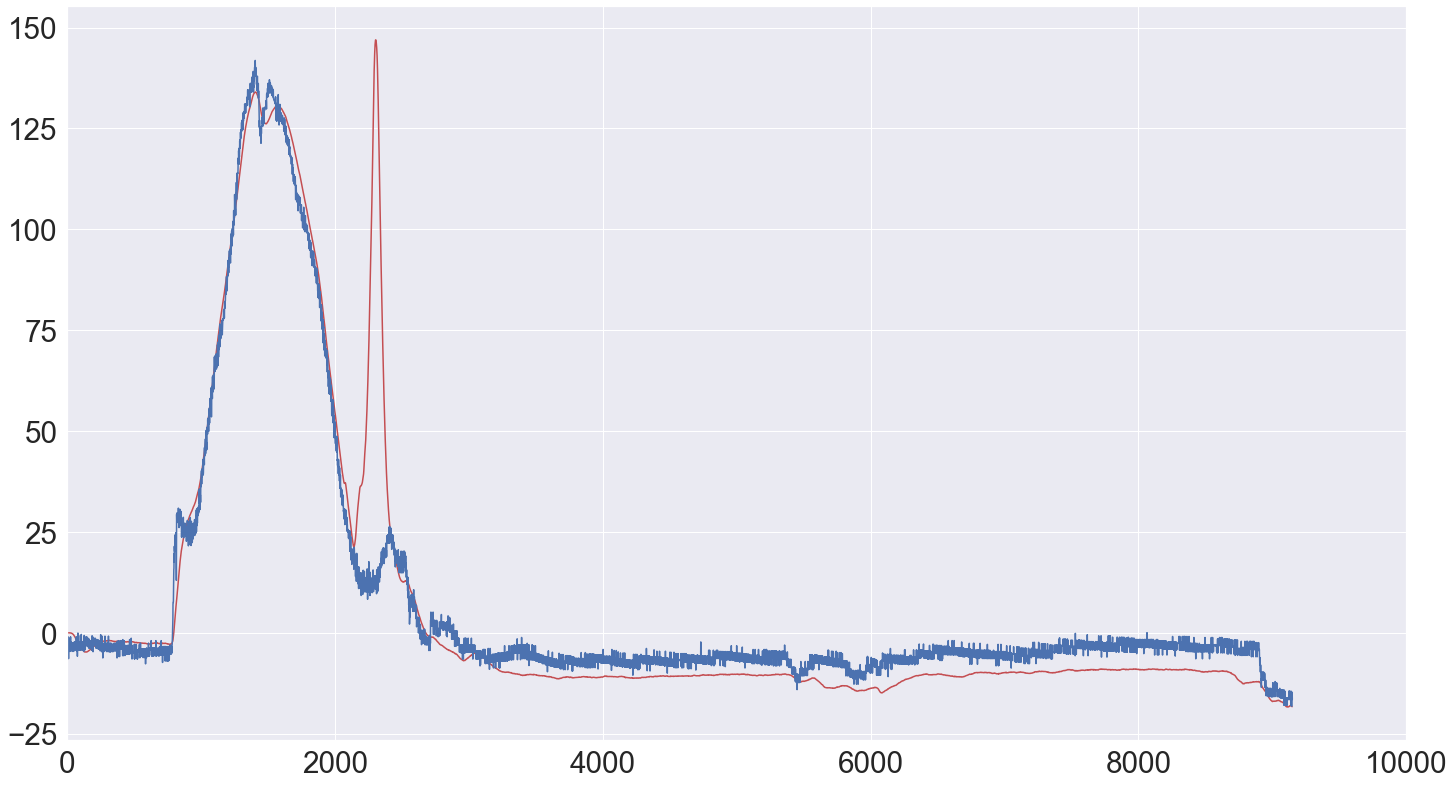

In [168]:
plt.plot(height, 'r')
plt.plot(agl, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

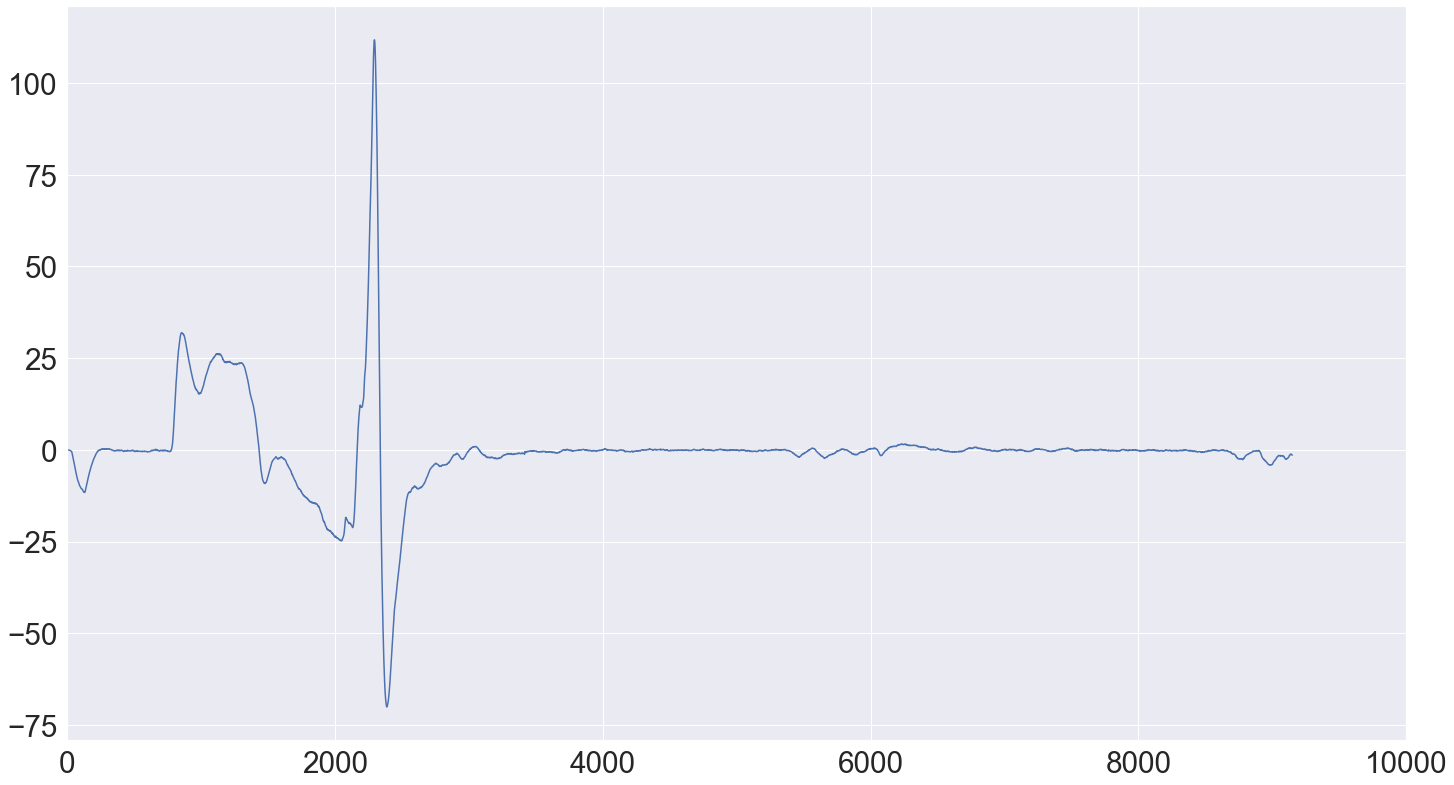

In [172]:
plt.plot(velocity, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

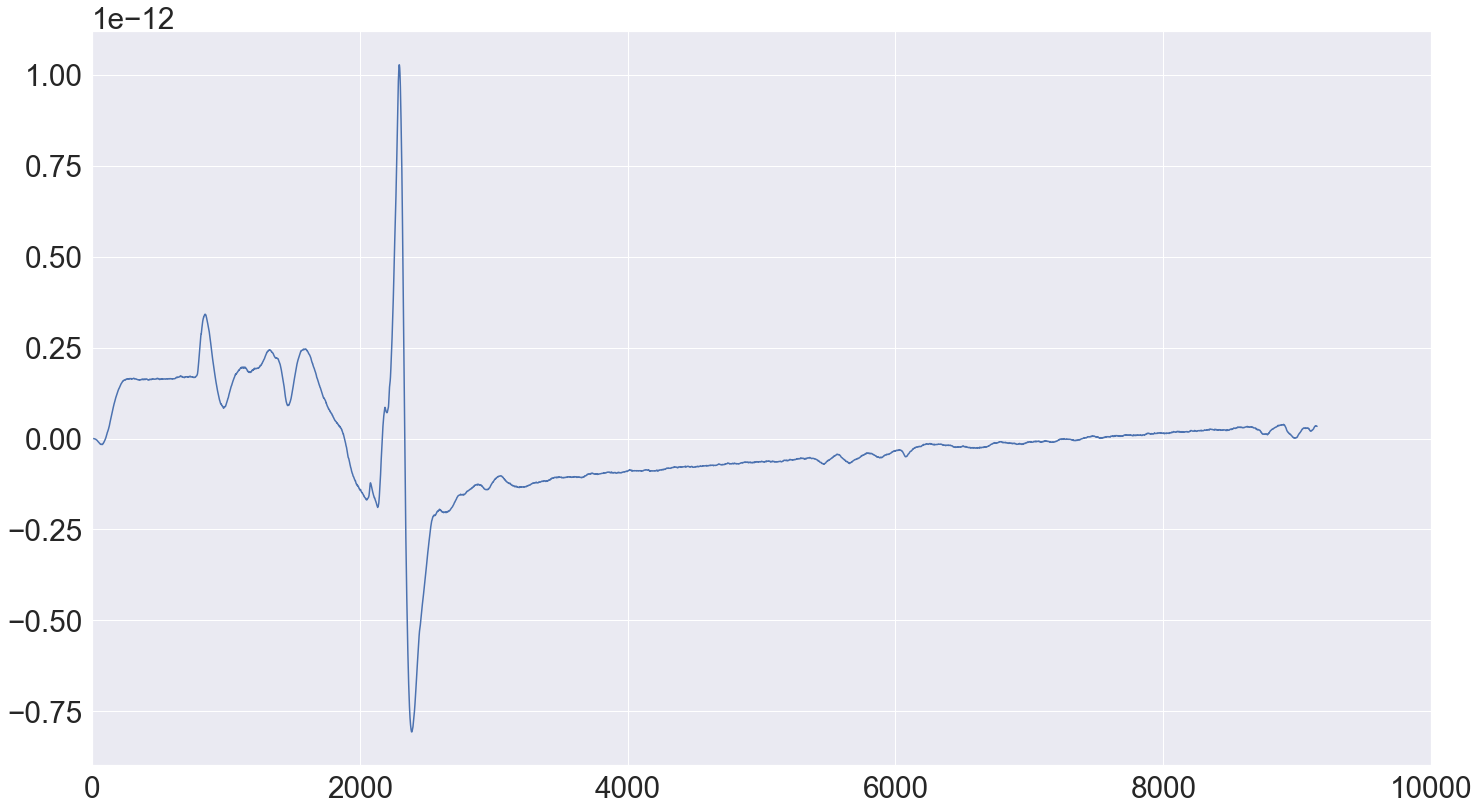

In [170]:
plt.plot(acc_offset, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

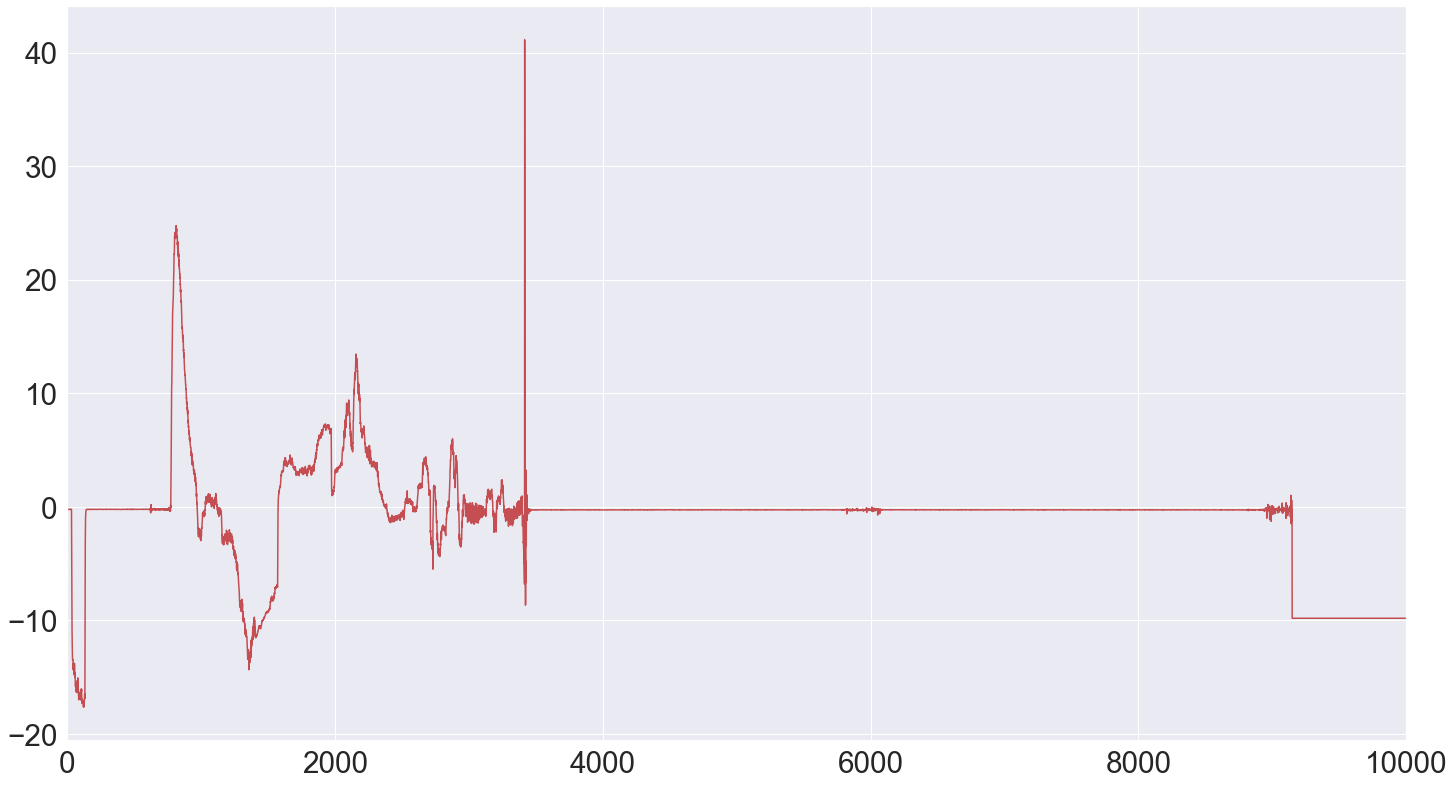

In [171]:
plt.plot(acc, 'r')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

In [45]:
max(height)

1539.7056735990482

In [46]:
max(velocity)

141.70815314328473

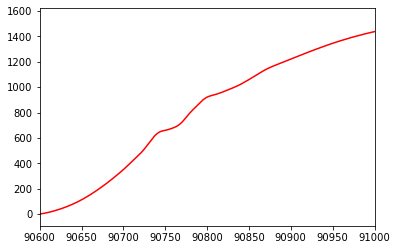

In [41]:
plt.plot(height, 'r')
axes = plt.gca()
axes.set_xlim([90600, 91000])
plt.show()

In [75]:
print(acc[90500])

-0.19


In [5]:
x_bar = np.array([[0],[0],[0]])
print(x_bar[1])

[0]
